# Chapter 2 : 介入効果を測るための回帰分析

### Agenda

- 回帰分析を用いて、セレクションバイアスの影響を低減させることができることを確認する
- Descriptive Toolとしてのregression
- Regressionとmatchingの関係
- `statsmodels`を使いこなす

### scope外

- 漸近分散の導出

### お作法

- seed = 42は宇宙の真理（seedガチャをやっていないことを示す）

In [1]:
## create the clean environment
import gc
import matplotlib.pyplot as plt

def clear_all():
    # Clears all the variables from the workspace
    gl = globals().copy()
    for var in gl:
        if var in clean_env_var: continue
        del globals()[var]
    # Garbage collection:
    gc.collect()

def close_plots():
  my_plots = plt.get_fignums()
  for j in my_plots:
    plt.close(plt.figure(j))

clean_env_var = dir()
clean_env_var.append('clean_env_var')

In [2]:
clear_all()

### Hardware

In [3]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [4]:
!python -V

Python 3.7.4


### Install Packages

In [5]:
pass

### Import

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as stats
from patsy import dmatrices
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from causalgraphicalmodels import CausalGraphicalModel
import propensity_score_matching as psmatch

## 1. Linear Regressionの紹介

OLSの推定量は以下のように導出される

$$
\beta = \arg\min_b \mathbf E[(Y_i - X_i'b)^2]
$$

Then, using FOC,

$$
E[X_i(Y_i - X_i'b)] = 0
$$

Then,

$$
\beta = E[X_iX_i']^{-1}E[X_iY_i]
$$

The sample analogue is

$$
\hat\beta = \sum_i^N (X_iX_i')^{-1}\sum_i^N (X_iY_i) = (X'X)^{-1}X'Y
$$




### OLSとEDA

`Daron Acemoglu, Simon Johnson, and James A Robinson. The colonial origins of comparative development: an empirical investigation. The American Economic Review, 91(5):1369–1401, 2001.`のデータを用いて、汚職の少なさなどの代表される政府組織の健全度と一人当たりGDPの関係を調べてみる。

### Read dta

In [7]:
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### GDP per capita と the protection against expropriation indexの関係

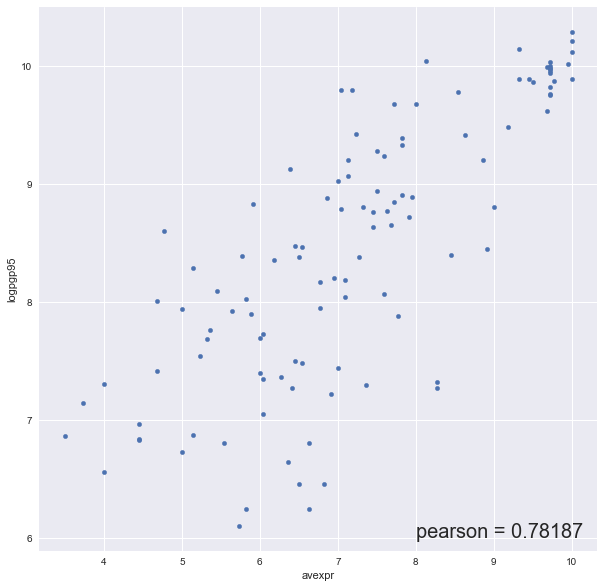

In [8]:
plt.style.use('seaborn')

df1.plot(x='avexpr', y='logpgp95', kind='scatter', figsize = (10, 10))
nas = np.logical_or(df1['avexpr'].isnull(), df1['logpgp95'].isnull())
pearson_corr = np.round(stats.pearsonr(df1.loc[~nas, 'avexpr'], df1.loc[~nas, 'logpgp95']), 5)
plt.text(8, 6, "pearson = {}".format(pearson_corr[0]), fontsize= 20)
plt.show()

Bivariate regressionでOLS estimatesを計算し、plotする

$$
{logpgp95}_i = \beta_0 + \beta_1 {avexpr}_i + u_i
$$

なお計算にあたってNAはdropする


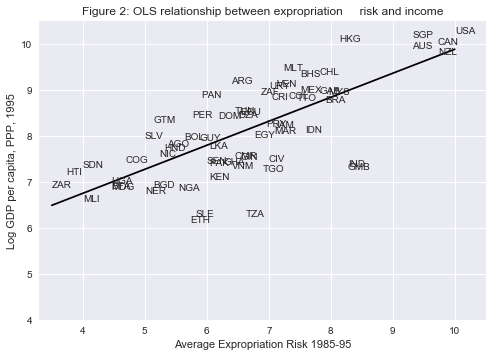

In [9]:
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])
df1_subset = df1_subset[df1_subset['baseco'] == 1] # base-sampleに絞る

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)), ## reduced-map
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
ax.set_title('Figure 2: OLS relationship between expropriation \
    risk and income')
plt.show()

## 2. statsmodels.apiとOLS

In [10]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     72.82
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           4.72e-12
Time:                        17:49:48   Log-Likelihood:                -68.168
No. Observations:                  64   AIC:                             140.3
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6604      0.409     11.408      0.0

### OLSとconfidence intervalのplot

まずsimulation dataを作る

In [11]:
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

Fit and summary

In [12]:
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     219.9
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           2.82e-27
Time:                        17:49:48   Log-Likelihood:                -35.297
No. Observations:                  50   AIC:                             78.59
Df Residuals:                      46   BIC:                             86.24
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4969      0.027     18.496      0.0

### Confidence intervalのplot

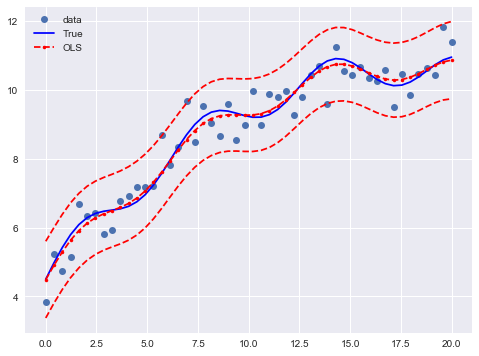

In [13]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

### OLS with dummy variables

In [14]:
nsample = 50
groups = np.zeros(nsample, int)
groups[20:40] = 1
groups[40:] = 2

dummy = sm.categorical(groups, drop=True)
x = np.linspace(0, 20, nsample)
# drop reference category
X = np.column_stack((x, dummy[:,1:]))
X = sm.add_constant(X, prepend=False)

beta = [1., 3, -3, 10]
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + e


res2 = sm.OLS(y, X).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     534.3
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           9.60e-36
Time:                        17:49:49   Log-Likelihood:                -71.625
No. Observations:                  50   AIC:                             151.3
Df Residuals:                      46   BIC:                             158.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9545      0.069     13.855      0.0

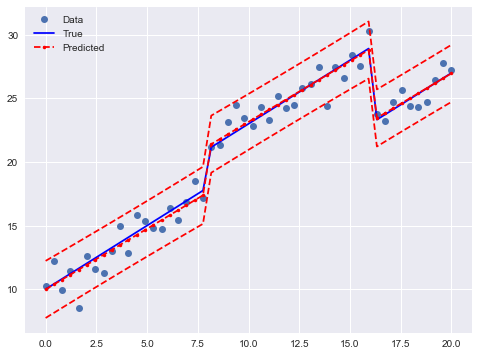

In [15]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res2.fittedvalues, 'r--.', label="Predicted")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
legend = ax.legend(loc="best")

## 3. 重回帰分析とselection-on-observables

`cps.csv`dataを用いて、なぜMultivariate regressionをするのか？, matching estimatorとはどのような関係にあるのかを学ぶ。

### Question

```
job trainingはearningに対して効果があるのか？、ATTの推定
```

### Question in detailed

`RE78`（７８年の収入）に対してtreatment（76年実施）はどの程度影響を与えているのか？


### Matching Strategy

1. treatedとcontrolの比較
2. job trainingの受講スクリーニングで用いる変数,$X_i$, が観測可能という前提のもと、それらをコントロールしてmatching比較する
3. 補足：$\epsilon_i = D_i - E[D_i|X_i]$は$(Y_1, Y_0)$と独立であるという仮定

つまり、
$$
(Y_1, Y_0) \perp D_i|X_i
$$



これをDAGで表現すると

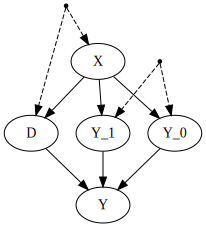

In [16]:
angrist = CausalGraphicalModel(
    nodes=["X", "D", "Y", "Y_1", "Y_0"],
    edges=[
        ("X", "D"), 
        ("D", "Y"),
        ("X", "Y_0"),
        ("X", "Y_1"),
        ("Y_1", "Y"),
        ("Y_0", "Y")
    ],
    latent_edges=[
        ("Y_1", "Y_0"),
        ("D", "X")]
)

# draw return a graphviz `dot` object, which jupyter can render
angrist.draw()

以下の場合はidentification strategyはアウト

- U: unobservables

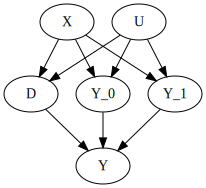

In [17]:
ill_angrist = CausalGraphicalModel(
    nodes=["X", "D", "Y", "U", "Y_1", "Y_0"],
    edges=[
        ("X", "D"), 
        ("D", "Y"),
        ("X", "Y_0"),
        ("X", "Y_1"),
        ("Y_1", "Y"),
        ("Y_0", "Y"),
        ("U", "Y_1"),
        ("U", "Y_0"),
        ("U", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
ill_angrist.draw()

### Justification for Identification Strategy

- datasetは実際に受講する意思を見せた（＝採用プロセスを受けた）人に限る
- 今回はATT, $E[Y_1 - Y_0|D_i = 1]$を求めたいので$(Y_0)$とは全く無関係の要因（採用通知連絡が郵便サービスの不備によって届かなかった等）によって決定されるならば良い
    - (極端な例) 採用プロセス後の受講、受講せずの結果は本人の意思ではなく、$X_i$で条件づけられた合格確率に応じてサイコロで決められた
    
なので以下の場合は許容される

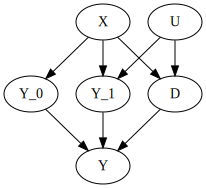

In [18]:
ok_angrist = CausalGraphicalModel(
    nodes=["X", "D", "Y", "U", "Y_1", "Y_0"],
    edges=[
        ("X", "D"), 
        ("D", "Y"),
        ("X", "Y_0"),
        ("X", "Y_1"),
        ("Y_1", "Y"),
        ("Y_0", "Y"),
        ("U", "Y_1"),
        ("U", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
ok_angrist.draw()

### Estimator

Let

$$
\delta_x \equiv E[Y_i|D_i = 1, X_i] - E[Y_i|D_i = 0, X_i]
$$

and 

$$
\widehat{ATT} = E[Y_{1i} - Y_{0i}|D_i = 1] = \sum_x\delta_xPr(X_i = x|D_i = 1)
$$

- $Pr(X_i = x|D_i = 1)$: $D_i = 1$, つまりveteranのXのdensity function

### Read training data

- control: `cps.csv`
- treated: `nswre74.csv`

この二つをmergeさせて分析する

#### 変数

- treat: treatment status
- re74, re75, re78: それぞれの年度の収入
- nodeg: 学位なし



In [19]:
data_control = pd.read_csv('./data/cps.csv')
data_control = data_control.iloc[:, 1:]
data_control.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,2025.0
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,441.0
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,1444.0
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,2304.0
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,324.0


In [20]:
data_treated = pd.read_csv('./data/nswre74.csv')
data_treated = data_treated.iloc[:, 1:]
data_treated.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1369.0
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,484.0
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,900.0
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,729.0
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,1089.0


In [21]:
var_info = dict({"treat": np.int,
                "age": np.int,
                "ed": np.int,
                "black":np.int,
                "hisp":np.int,
                "married":np.int,
                "nodeg":np.int,
                "re74":np.float,
                "re75":np.float,
                "re78":np.float,
                "age2":np.int,
                })

### 変数type変換

In [22]:
data_treated = data_treated.astype(var_info)
data_control = data_control.astype(var_info)
data_control.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,0,45,11,0,0,1,1,21516.670,25243.550,25564.670,2025
1,0,21,14,0,0,0,0,3175.971,5852.565,13496.080,441
2,0,38,12,0,0,1,0,23039.020,25130.760,25564.670,1444
3,0,48,6,0,0,1,1,24994.370,25243.550,25564.670,2304
4,0,18,8,0,0,1,1,1669.295,10727.610,9860.869,324


### merge

In [23]:
merged_df = pd.concat([data_control, data_treated], axis = 0)
merged_df = merged_df.reset_index(drop = True)
merged_df = merged_df.sample(frac=1.0, random_state=42)  # Shuffle
merged_df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
2616,0,41,13,0,0,1,0,25862.32000,0.000,0.000,1681
5422,0,19,12,0,0,0,0,3291.56800,12303.100,19260.690,361
3980,0,54,6,1,0,0,1,9500.48500,8706.339,4722.814,2916
11076,0,28,12,1,0,1,0,0.00000,0.000,0.000,784
7930,0,44,12,0,1,1,0,66.61507,0.000,0.000,1936


### EDA

In [24]:
merged_df.describe()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
count,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,0.011255,33.012594,11.977916,0.094117,0.072458,0.697025,0.308998,13694.237302,13318.517623,14588.222993,1211.504654
std,0.105495,11.030899,2.862478,0.292000,0.259253,0.459558,0.462094,9675.637887,9372.831224,9702.608292,782.038511
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,256.000000
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3644.236000,3695.897000,5088.760000,576.000000
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14655.320000,14109.530000,15962.400000,961.000000
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23360.340000,22703.080000,25564.670000,1764.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,25243.550000,60307.930000,3025.000000


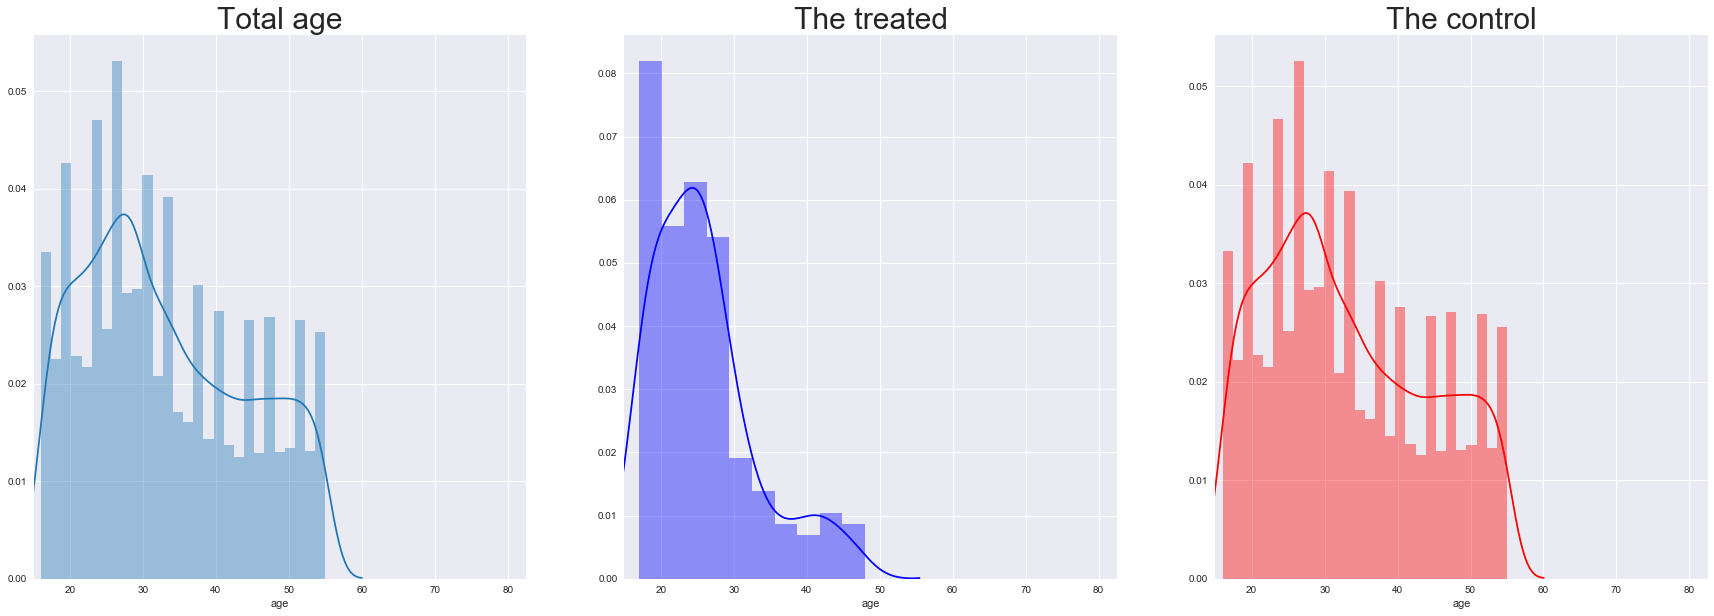

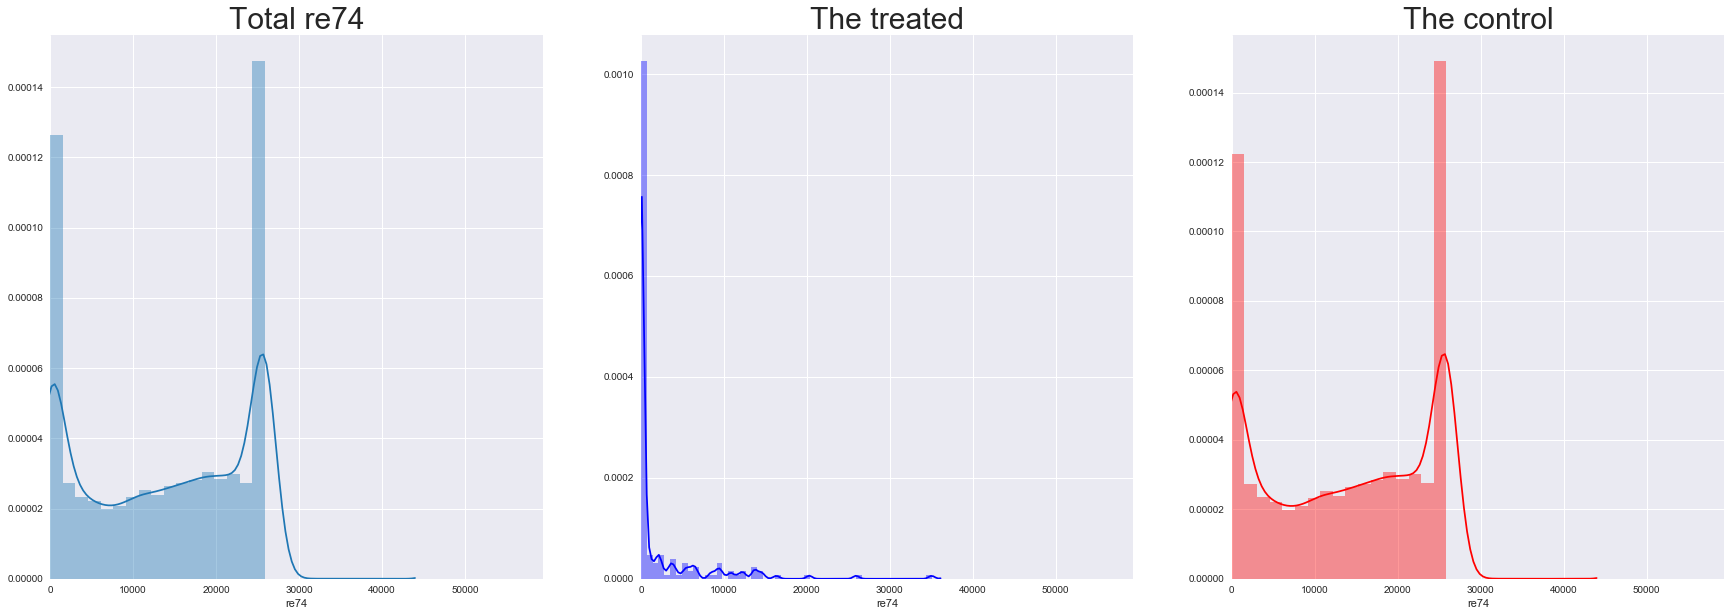

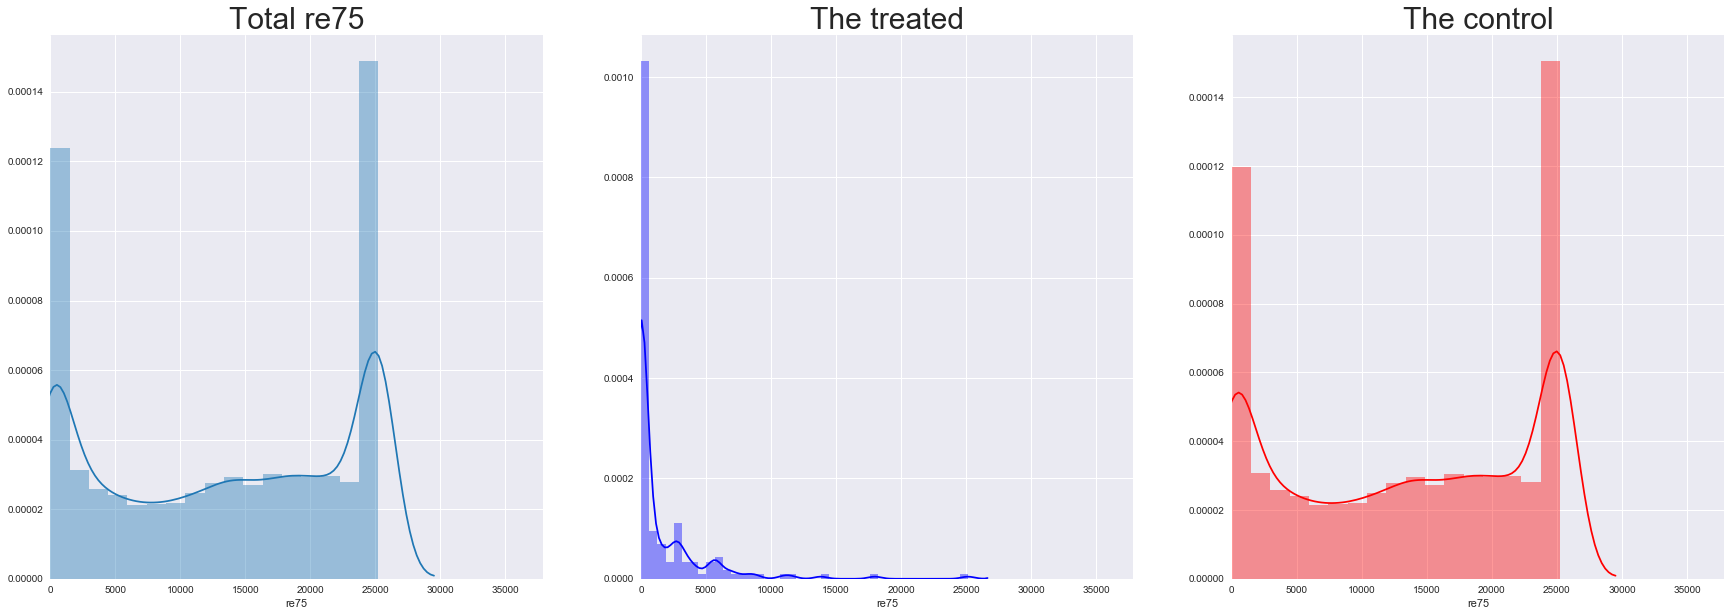

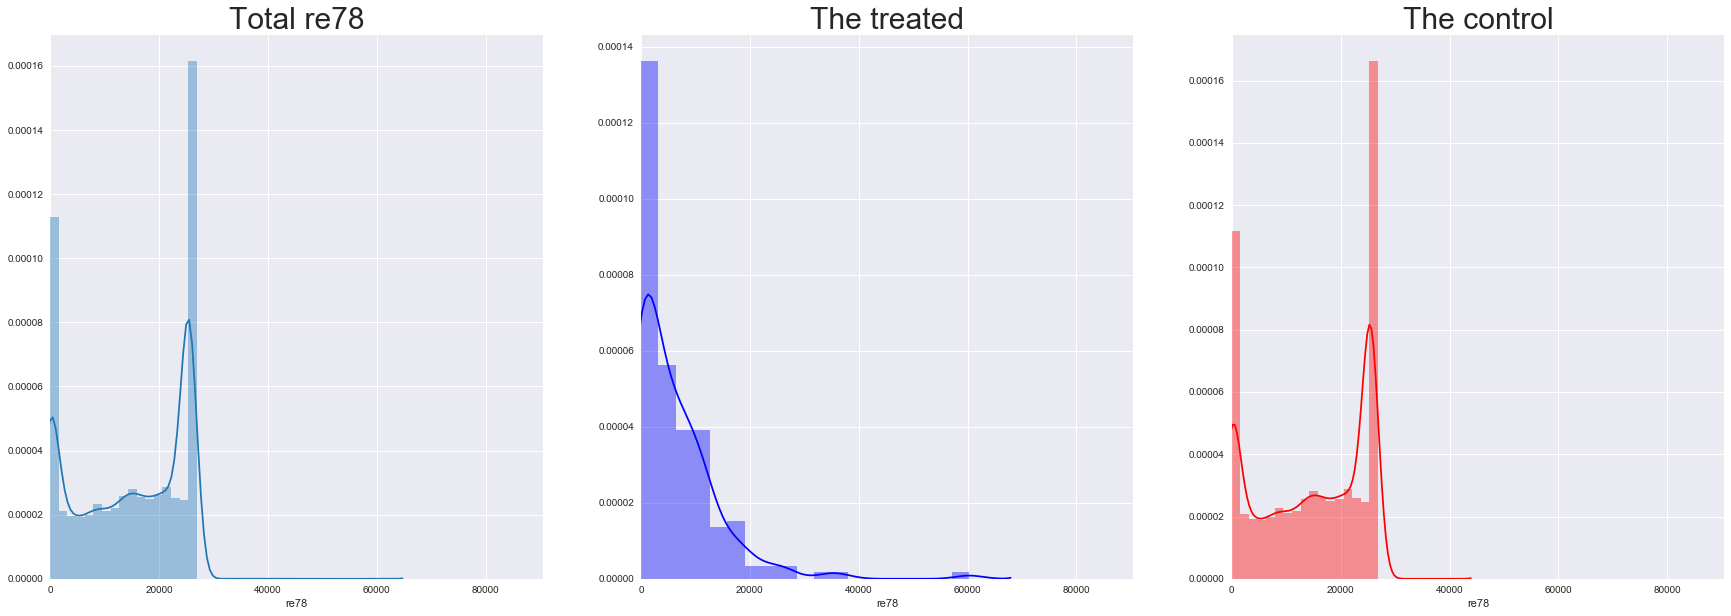

In [25]:
columns = ['age', 're74', 're75', 're78']
for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    sns.distplot(merged_df[column], color="#1f77b4", ax = axs[0]).set_title('Total ' + column,fontsize=30)
    sns.distplot(merged_df[merged_df['treat'] >= .5][column], color="blue", ax = axs[1]).set_title('The treated',fontsize=30)
    sns.distplot(merged_df[merged_df['treat'] < .5][column], color="red", ax = axs[2]).set_title('The control',fontsize=30)
    for j in range(0, 3):
        axs[j].set_xlim(min(merged_df[column])-1, max(merged_df[column]*1.5 ))
    plt.show()

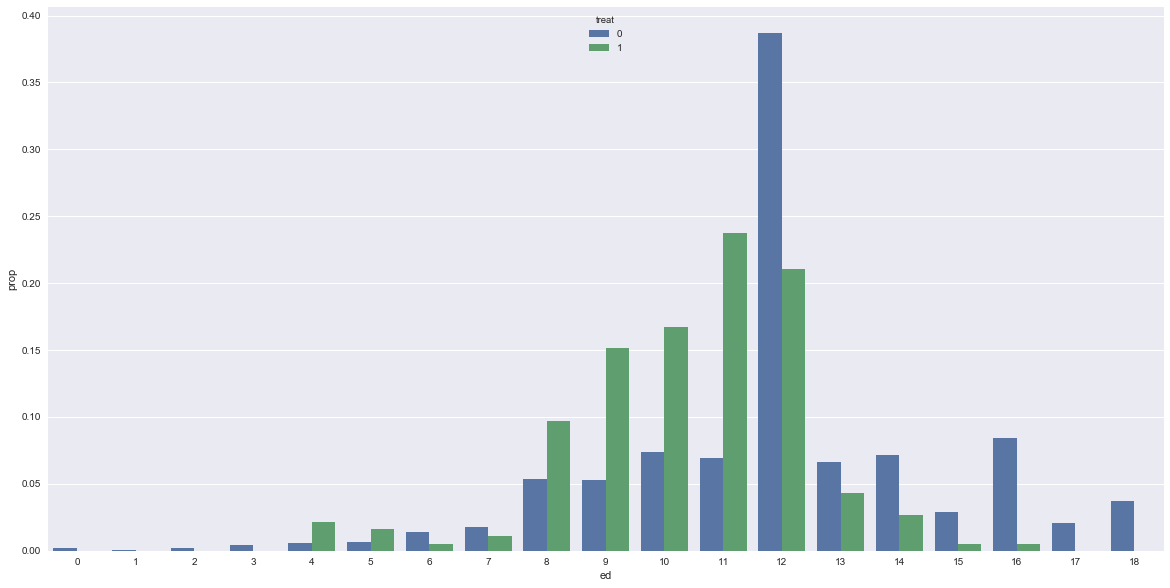

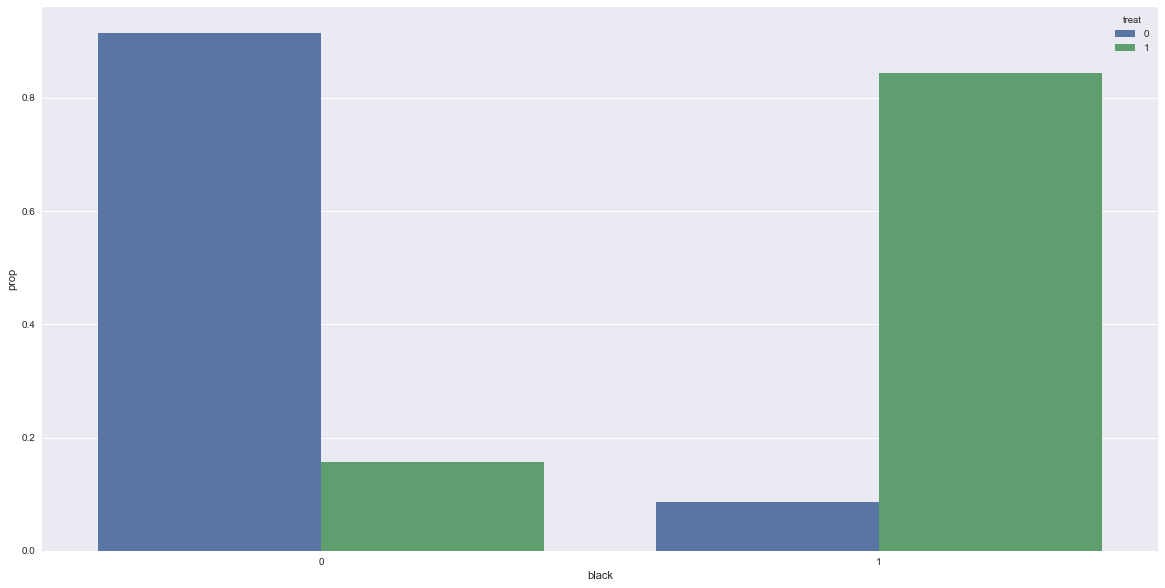

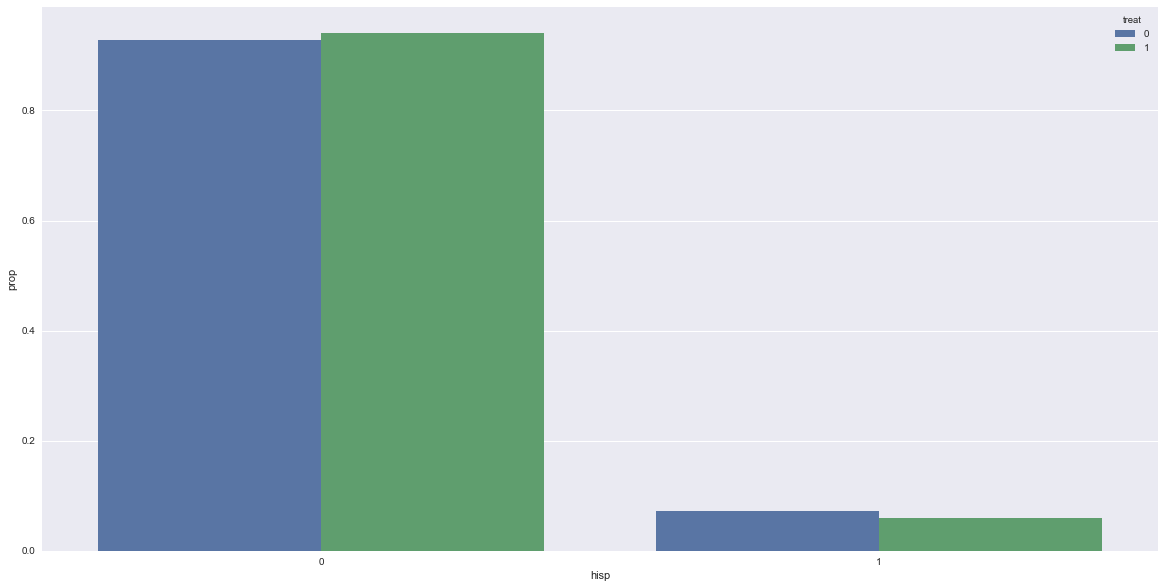

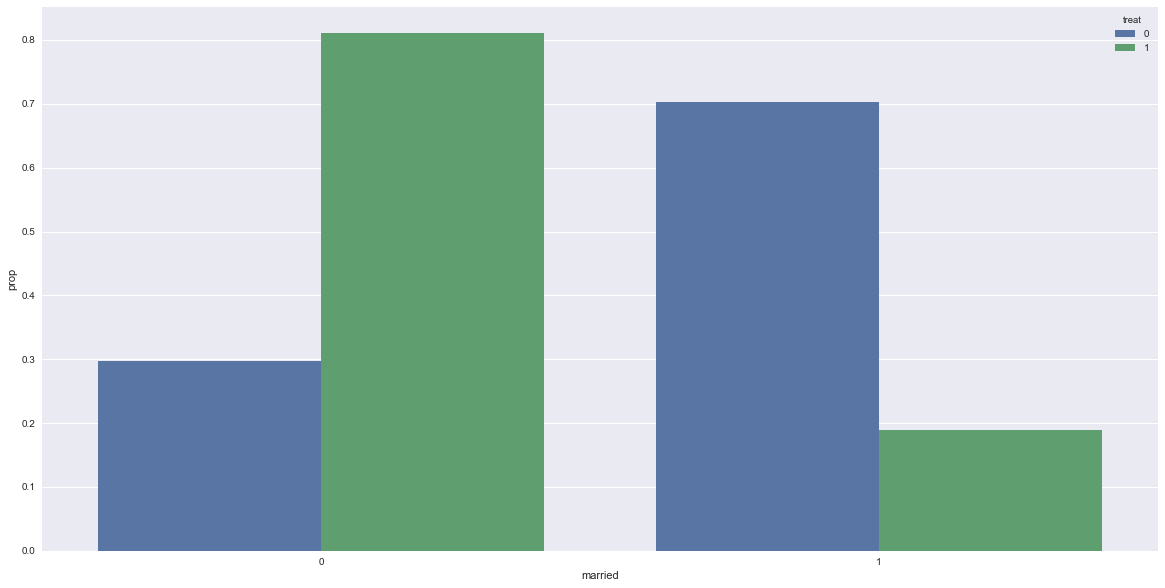

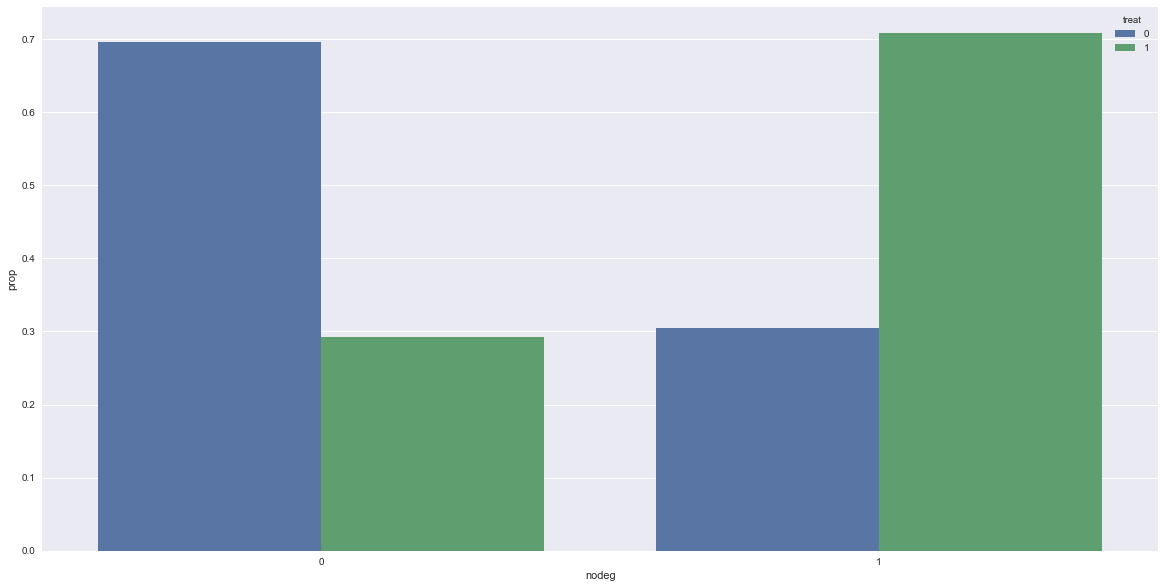

In [26]:
columns = ['ed', 'black', 'hisp', 'married', 'nodeg']
hue = 'treat'
y = 'prop'

for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
    prop_df = (merged_df.groupby("treat")[column]
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())
    
    sns.barplot(x=column, y=y, hue = hue, data=prop_df, ax=axs)

### Normalized Difference

ATE, ATT, ATCの推定にはcommon support, overlapが必要条件だがその確認のための統計量としてNormazlied Differenceがある。

$$
\text{Normalized Difference}_j = \frac{|\bar x_{treated, j} - \bar x_{control, j}|}{(s_{treated, j}^2 + s_{control, j}^2)^{1/2}}
$$

- j: covariateのindex
- Imbens and Rubinはnormalized differenceが0.25を超えた場合、overlapに問題があるとしている


In [27]:
colnames = list(merged_df.columns)
for i in ['treat', 're78']:
    colnames.remove(i)
normed_diff = merged_df.groupby(['treat']).agg([np.mean, 'var'])
normed_diff

age                     ed               black            \
            mean         var       mean       var      mean       var   
treat                                                                   
0      33.094511  121.890027  11.996493  8.210621  0.085589  0.078269   
1      25.816216   51.194301  10.345946  4.042714  0.843243  0.132902   

           hisp             married               nodeg            \
           mean       var      mean       var      mean       var   
treat                                                               
0      0.072606  0.067339  0.702806  0.208883  0.304455  0.211775   
1      0.059459  0.056228  0.189189  0.154230  0.708108  0.207814   

               re74                        re75                        re78  \
               mean           var          mean           var          mean   
treat                                                                         
0      13826.267376  9.286444e+07  13452.685450  8.713324e+07  14682.010201   
1       2095.573689  2.387906e+07   1532.055314  1.036358e+07   6349.143530   

                            age2                 
                var         mean            var  
treat                                            
0      9.372992e+07  1217.129215  613629.780115  
1      6.189602e+07   717.394595  185978.033666

In [28]:
def compute_normed_diff(df, feature, round_digits = 5):
    snd = []
    for i in feature:
        tmp_df = df[i].values
        neg_mean = tmp_df[0, 0]
        neg_std = tmp_df[0, 1]
        pos_mean = tmp_df[1, 0]
        pos_std = tmp_df[1, 1]
        smd = (pos_mean - neg_mean) / np.sqrt((pos_std+ neg_std) / 2)
        smd = round(abs(smd), round_digits)
        snd.append(smd)

    return pd.DataFrame({'features': feature, 'snd': snd})
    

In [29]:
snd = compute_normed_diff(normed_diff, feature = colnames)
snd

,features,snd
0,age,0.78238
1,ed,0.66683
2,black,2.33168
3,hisp,0.05289
4,married,1.20541
5,nodeg,0.88127
6,re74,1.53540
7,re75,1.70734
8,age2,0.79034


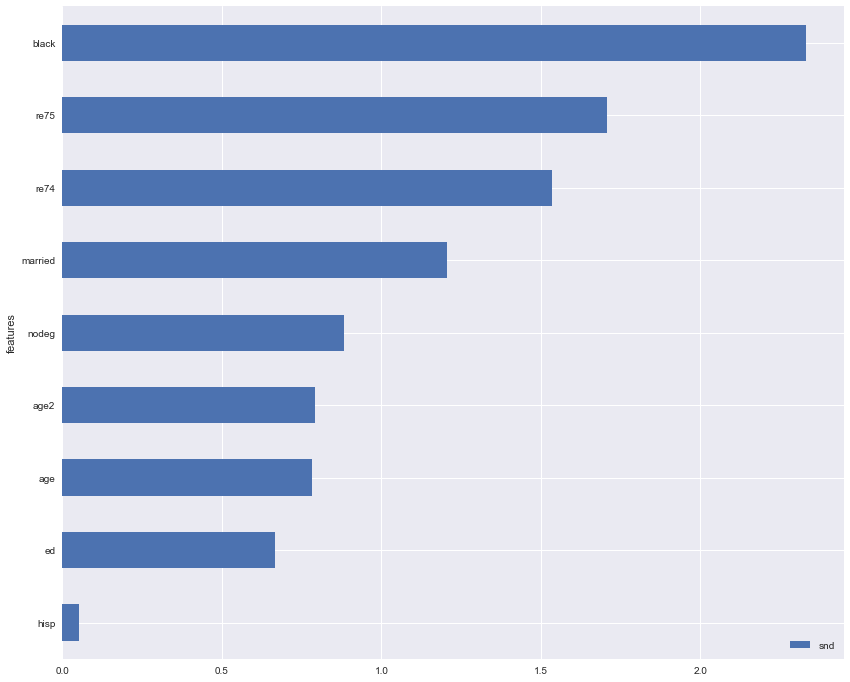

In [30]:
snd = snd.sort_values('snd')
snd.plot.barh(x='features', y='snd', figsize=(14,12));

### Naive estimator

In [31]:
#merged_df = pd.get_dummies(merged_df, columns=["ed"], drop_first=True)
merged_df = merged_df.join((merged_df[["re74", "re75"]] == 0).astype(int), rsuffix=("_0"))


In [32]:
treatment_params = dict()

In [33]:
naive = merged_df.groupby('treat')['re78'].mean()
naive[2] = naive[1] - naive[0]
res = pd.DataFrame(naive.reset_index(drop = True)).T
res.columns = ['control mean', 'treated mean', 'mean diff']
res

,control mean,treated mean,mean diff
re78,14682.010201,6349.14353,-8332.86667


In [34]:
treatment_params['naive'] = res['mean diff'].values[0]

### OLS estimator

In [35]:
X = merged_df.drop('re78', axis = 1)
Y = merged_df.loc[:,'re78']
X = sm.add_constant(X)
ols_res = sm.OLS(Y, X).fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1279.
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:50:01   Log-Likelihood:            -1.6879e+05
No. Observations:               16437   AIC:                         3.376e+05
Df Residuals:                   16424   BIC:                         3.377e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7213.9852    728.641      9.901      0.0

In [36]:
treatment_params['OLS'] = ols_res.params['treat']

### Propensity Score matching

In [37]:
merged_df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2,re74_0,re75_0
2616,0,41,13,0,0,1,0,25862.32000,0.000,0.000,1681,0,1
5422,0,19,12,0,0,0,0,3291.56800,12303.100,19260.690,361,0,0
3980,0,54,6,1,0,0,1,9500.48500,8706.339,4722.814,2916,0,0
11076,0,28,12,1,0,1,0,0.00000,0.000,0.000,784,1,1
7930,0,44,12,0,1,1,0,66.61507,0.000,0.000,1936,0,1


In [38]:
logit_formula = 'treat~ 1+age+black+hisp+married+nodeg+re74+re75+age2+ed+re74_0+re75_0'

In [39]:
logit_res = smf.logit(formula=logit_formula, data=merged_df).fit()
propensity_score = logit_res.predict()
merged_df['p_logit'] = propensity_score

Optimization terminated successfully.
         Current function value: 0.032973
         Iterations 12


common supportのvisualization

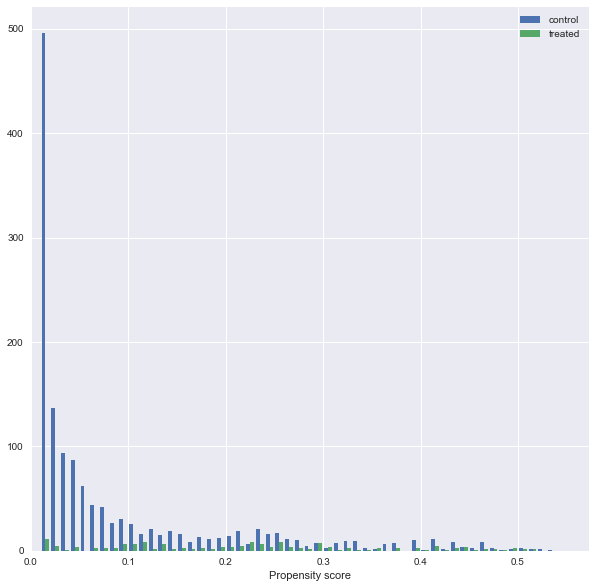

In [40]:
prob_untreated = merged_df.loc[merged_df['treat'] == 0, 'p_logit']
prob_treated =  merged_df.loc[merged_df['treat'] == 1, 'p_logit']
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
bins = np.linspace(0.01, 1.00, 100)
ax.hist([prob_untreated, prob_treated], bins=bins, label=['control', 'treated'])
ax.set_xlim([0, max(merged_df['p_logit'])])
ax.set_xlabel('Propensity score')
ax.legend();

propensity scoreを用いたATE, ATT, ATCの推定

In [41]:
treatment_params['PS_ATT'] = psmatch.get_att_weight(merged_df, p = propensity_score, outcome = 're78', treat = 'treat' )
treatment_params['PS_ATE'] = psmatch.get_ate_weight(merged_df, p = propensity_score, outcome = 're78', treat = 'treat' )
treatment_params['PS_ATC'] = psmatch.get_atc_weight(merged_df, p = propensity_score, outcome = 're78', treat = 'treat' )

### Nearest Neighbour Matching

In [42]:
treated_df = merged_df.loc[merged_df['treat'] == 1].reset_index(drop = True)
non_treated_df = merged_df.loc[merged_df['treat'] == 0].reset_index(drop = True)

In [43]:
treated = treated_df['p_logit'].values
non_treated = non_treated_df['p_logit'].values

nbrs = NearestNeighbors(n_neighbors=1,
                        algorithm='ball_tree').fit(non_treated.reshape(-1, 1))
distances, indices = nbrs.kneighbors(treated.reshape(-1, 1))
indices = indices.reshape(indices.shape[0])
matched = non_treated_df.loc[indices]

どの程度マッチしているか可視化してみる

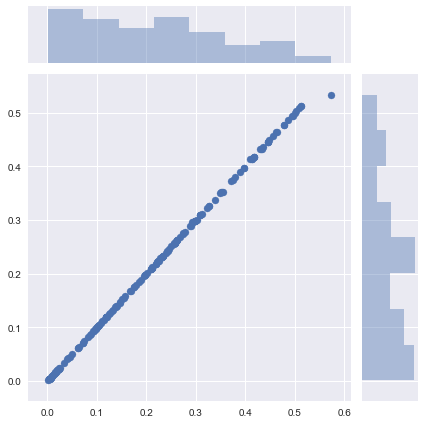

In [44]:
sns.jointplot(treated, matched['p_logit'].values);

In [45]:
treatment_params['Nearest_ATT'] = np.mean(treated_df['re78']) - np.mean(matched['re78'])
treatment_params['Nearest_ATT']

1224.839727675675

ATCも計算してみる

In [46]:
nbrs = NearestNeighbors(n_neighbors=1,
                        algorithm='ball_tree').fit(treated.reshape(-1, 1))
distances, indices = nbrs.kneighbors(non_treated.reshape(-1, 1))
indices = indices.reshape(indices.shape[0])
matched_atc = treated_df.loc[indices]

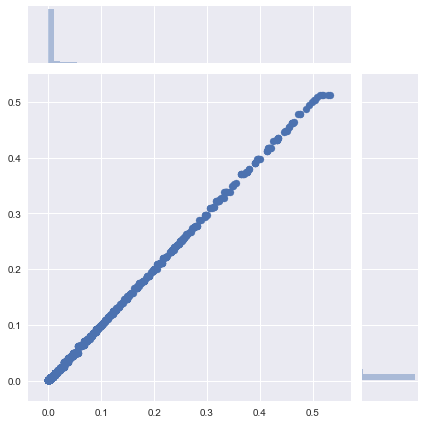

In [47]:
sns.jointplot(non_treated, matched_atc['p_logit'].values);

In [48]:
treatment_params['Nearest_ATC'] = np.mean(matched_atc.re78) - np.mean(non_treated_df['re78'])
treatment_params['Nearest_ATC'] 

-3653.6808865858366

CIAのAssumptionが成立していないと思われる

### 統計量の比較

In [49]:
pd.DataFrame(treatment_params.values(),
             index = treatment_params.keys(),
             columns = ['effect_size'])

,effect_size
naive,-8332.866670
OLS,1204.027732
PS_ATT,1402.255464
PS_ATE,-6779.472819
PS_ATC,-6872.607186
Nearest_ATT,1224.839728
Nearest_ATC,-3653.680887


Propensity Score ATTの推定とOLSの推定は比較的近い値を計算している。

### Regression Meets Matching

The Horvitz-Thompson matching estimandsを振り返る:

$$
E[Y_{1i} - Y_{0i}] = E\left[\frac{D_i - P(X)i)Y_i}{P(X_i)(1 - P(X_i))}\right]
$$

and

$$
E[Y_{1i} - Y_{0i}|D_i = 1] = E\left[\frac{D_i - P(X)i)Y_i}{\rho(1 - P(X_i))}\right]
$$

where $\rho$はsampleのtreated割合。

Hirano, Imbens, and Ridder(2003)はregressionとThe Horvitz-Thompson matching estimandsが同じweighted average estimand classに属することを示した：

$$
E\left\{g(X_i)\left[\frac{D_iY_i}{P(X_i)} - \frac{(1 - D_i)Y_i}{(1 - P(X_i))} \right]\right\}
$$

- $g(X_i) = 1$: ATE
- $g(X_i) = p(X_i)/P(D_i = 1)$: ATT
- $g(X_i) = p(X_i)(1 - p(X_i))/E[p(X_i)(1 - p(X_i))]$: OLS

よって、OLSは$p(X_i)(1 - p(X_i))$が大きいところ＝treatment assignmentが50:50に近いところに大きいweightを置いている事がわかる。上のpropensity scoreの分布と照らし合わせると、ATTと近い間が出る。

## 4. メールマーケティングデータの分析（回帰編）

biased datasetを用いて重回帰分析によってどの程度biasが除去できるか検討する。EDAについてはch01参照。

In [50]:
df = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.009031,1.050908
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.094604,15.036448
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000


バイアスのあるデータを作成

In [51]:
## 前処理
df.loc[:, 'treatment'] = df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df = df.loc[df['segment'] != 'Womens E-Mail']
male_df.info()
male_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42613 entries, 1 to 63999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          42613 non-null  int64  
 1   history_segment  42613 non-null  object 
 2   history          42613 non-null  float64
 3   mens             42613 non-null  int64  
 4   womens           42613 non-null  int64  
 5   zip_code         42613 non-null  object 
 6   newbie           42613 non-null  int64  
 7   channel          42613 non-null  object 
 8   segment          42613 non-null  object 
 9   visit            42613 non-null  int64  
 10  conversion       42613 non-null  int64  
 11  spend            42613 non-null  float64
 12  treatment        42613 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 4.6+ MB


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


In [52]:
def bias(s):
  loyal = s['history'] > 300 or s['recency'] < 3 or s['channel'] == 'Multichannel'
  if (s['treatment'] == 1 and not loyal) or (s['treatment'] == 0 and loyal):
    return 0.5
  else:
    return 1.0

biased_data = male_df.sample(frac=0.5, weights=male_df.apply(bias, axis=1), random_state=42)
biased_data.info()
biased_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21306 entries, 24106 to 56013
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          21306 non-null  int64  
 1   history_segment  21306 non-null  object 
 2   history          21306 non-null  float64
 3   mens             21306 non-null  int64  
 4   womens           21306 non-null  int64  
 5   zip_code         21306 non-null  object 
 6   newbie           21306 non-null  int64  
 7   channel          21306 non-null  object 
 8   segment          21306 non-null  object 
 9   visit            21306 non-null  int64  
 10  conversion       21306 non-null  int64  
 11  spend            21306 non-null  float64
 12  treatment        21306 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.3+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend,treatment
count,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000
mean,5.783958,241.820497,0.550690,0.549188,0.502347,0.145593,0.009152,1.098233,0.483291
std,3.518513,258.443012,0.497436,0.497586,0.500006,0.352706,0.095231,15.986469,0.499732
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,156.125000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,324.927500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,12.000000,3215.970000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000,1.000000


In [53]:
## OLSをstatsmodels apiで実行
y, X = dmatrices('spend ~ treatment + history', data = biased_data, return_type='dataframe')
model = sm.OLS(y, X)
res = model.fit()

In [54]:
summary = res.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.35
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           3.21e-05
Time:                        17:51:06   Log-Likelihood:                -89276.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21303   BIC:                         1.786e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4921      0.176      2.792      0.0

### REMARKS
- Rの実行結果と異なる理由は、biased_data作成がランダムサンプルのため

In [55]:
## 推定されたパラメーターを取り出す
coef = summary.tables[1]
print(type(coef))
print(coef)

<class 'statsmodels.iolib.table.SimpleTable'>
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4921      0.176      2.792      0.005       0.147       0.838
treatment      0.8483      0.221      3.836      0.000       0.415       1.282
history        0.0008      0.000      1.897      0.058    -2.7e-05       0.002


なおパラメータのみを取り出したいときは

In [56]:
print(res.params)

Intercept    0.492055
treatment    0.848338
history      0.000811
dtype: float64


residualも一応計算

In [57]:
beta = res.params.values
beta.shape = 3, 1
beta.shape
residual = y.values - X.values @ beta 

In [58]:
residual.shape

(21306, 1)

不均一分散かどうかplotで確認

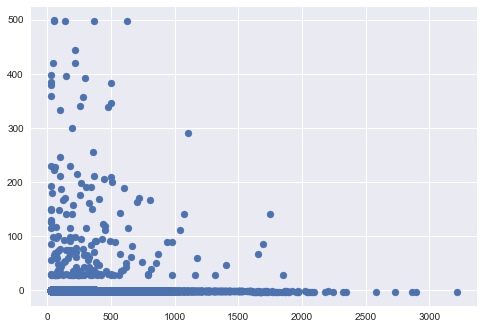

In [59]:
plt.scatter(X['history'], residual);

### 不均一分散の検定

- ブルーシュ＝ペーガン検定
- ホワイト検定

#### ホワイト検定とブルーシュ＝ペーガン検定

どちらもresidualsの自乗を説明変数に回帰させ、F testを実施する。

- 1次の項のみ：ブルーシュ＝ペーガン検定
- 2次の項も含む：ホワイト検定


In [60]:
white_test = het_white(residual,  X)
bp_test = het_breuschpagan(residual,  X)

In [61]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
df1 = pd.DataFrame(dict(zip(labels, bp_test)).values(), 
                   index = dict(zip(labels, bp_test)).keys(),
                   columns = ['bq test'])

df2 = pd.DataFrame(dict(zip(labels, white_test)).values(), 
                   index = dict(zip(labels, bp_test)).keys(),
                   columns = ['white test'])

pd.concat([df1, df2], axis = 1)

,bq test,white test
LM Statistic,9.664875,10.198808
LM-Test p-value,0.007967,0.037209
F-Statistic,4.833950,2.550324
F-Test p-value,0.007964,0.037201


不均一分散が存在すると解釈できる。なのでOLSを用いるときはWhiteのheteroskedasticity-robust standard errorを用いてregressionを実施すべきと解釈できる。

### heteroskedasticity robust standard errors

`fit()`methodを呼ぶときに`cov_type`をしてするだけで良い

In [62]:
res_white = model.fit(cov_type = 'HC0', use_t = True)
summary = res_white.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.477
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           7.69e-05
Time:                        17:51:06   Log-Likelihood:                -89276.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21303   BIC:                         1.786e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4921      0.147      3.347      0.0

## 5. 回帰分析におけるバイアス

In [63]:
## RCTデータでの単回帰
y, X = dmatrices('spend ~ treatment', data = male_df, return_type = 'dataframe')
results_unbiased_1 = sm.OLS(y, X).fit()
rct_reg_coef = results_unbiased_1.summary().tables[1]
rct_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6528,0.103,6.356,0.000,0.451,0.854
treatment,0.7698,0.145,5.300,0.000,0.485,1.055


In [64]:
y, X = dmatrices('spend ~ treatment + recency + channel + history', data = male_df, return_type = 'dataframe')
results_unbiased_2 = sm.OLS(y, X).fit()
biased_reg_coef = results_unbiased_2.summary().tables[1]
biased_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4815,0.306,1.572,0.116,-0.119,1.082
channel[T.Phone],0.1361,0.256,0.533,0.594,-0.365,0.637
channel[T.Web],0.3068,0.255,1.203,0.229,-0.193,0.807
treatment,0.7677,0.145,5.287,0.000,0.483,1.052
recency,-0.0525,0.021,-2.459,0.014,-0.094,-0.011
history,0.0012,0.000,3.641,0.000,0.001,0.002


In [65]:
## バイアスのあるデータでの単回帰
y, X = dmatrices('spend ~ treatment', data = biased_data, return_type = 'dataframe')
results_biased_1 = sm.OLS(y, X).fit()
rct_reg_coef = results_biased_1.summary().tables[1]
rct_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6604,0.152,4.336,0.000,0.362,0.959
treatment,0.9060,0.219,4.135,0.000,0.477,1.335


In [66]:
## バイアスのあるデータでの重回帰
y, X = dmatrices('spend ~ treatment + recency + channel + history', data = biased_data, return_type = 'dataframe')
results_biased_2 = sm.OLS(y, X).fit()
biased_reg_coef = results_biased_2.summary().tables[1]
biased_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6927,0.469,1.477,0.140,-0.226,1.612
channel[T.Phone],-0.0521,0.386,-0.135,0.893,-0.809,0.705
channel[T.Web],0.2999,0.386,0.777,0.437,-0.456,1.056
treatment,0.8181,0.222,3.680,0.000,0.382,1.254
recency,-0.0480,0.032,-1.489,0.136,-0.111,0.015
history,0.0007,0.000,1.526,0.127,-0.000,0.002


まとめて表示

In [67]:
results = [results_unbiased_1, results_unbiased_2, results_biased_1, results_biased_2]
reg_names = ['Unbiased Model', 'Unbiased Model 2', 'Biased Model 1', 'Biased Model 2']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'treatment',
                   'channel[T.Phone]',
                   'channel[T.Web]',
                   'recency',
                   'history']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table  - OVB mail marketing')
print(results_table)

                         Table  - OVB mail marketing
                 Unbiased Model Unbiased Model 2 Biased Model 1 Biased Model 2
------------------------------------------------------------------------------
Intercept        0.653***       0.482            0.660***       0.693         
                 (0.103)        (0.306)          (0.152)        (0.469)       
treatment        0.770***       0.768***         0.906***       0.818***      
                 (0.145)        (0.145)          (0.219)        (0.222)       
channel[T.Phone]                0.136                           -0.052        
                                (0.256)                         (0.386)       
channel[T.Web]                  0.307                           0.300         
                                (0.255)                         (0.386)       
recency                         -0.053**                        -0.048        
                                (0.021)                         (0.032)       

### REMARKS

dmatricesはカテゴリ変数のダミー変数化も勝手にやってくれる


## 6. Omitted Variables Bias

### OVB simulation
OVBをsimulation dataで確かめてみる。モデルは以下

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i
$$

$(\beta_0, \beta_1, \beta_2) = (1, 2, 1)$とする。また、$(x_1, x_2)$はi.i.d sampleで分布は以下のように設定する

$$
\left(\begin{array}{c}x_1\\x_2\end{array}\right) \sim N \left(
\left(\begin{array}{c}3\\4\end{array}\right) , \left(\begin{array}{cc}2&1\\1&2\end{array}\right) 
\right)
$$

$\epsilon_i$もi.i.d from $N(0, 1)$とする。sample size = 200, 試行回数500で$\hat\beta_{1ols}$と$\hat\beta_{1ovb}$の分布を確かめる。

In [68]:
def generate_data(cov_matrix):
    mu = np.array([3, 4])
    N = 200
    beta = np.array([2., 1.], dtype = np.float)
    
    X = np.random.default_rng().multivariate_normal(mean = mu,
                                                    cov = cov_matrix, size = N, 
                                                    method = 'cholesky')
    error = np.random.normal(0, 1, N)
    y = X @ beta + error + 1
    
    return X, y

def reg_ols(y, X):
    X = sm.add_constant(X)
    reg_ols = sm.OLS(y, X).fit()
    reg_ovb = sm.OLS(y, X[:, :-1]).fit()
    beta_ols = reg_ols.params[1]
    beta_ovb = reg_ovb.params[1]
    
    return beta_ols, beta_ovb

def simulation(cov_matrix = np.array([[2, 1], [1, 2]]), trial = 500):
    ols = []
    ovb = []
    
    for i in range(trial):
        X_1, y_1 = generate_data(cov_matrix = cov_matrix)
        beta_ols, beta_ovb = reg_ols(y = y_1, X = X_1)
        ols.append(beta_ols)
        ovb.append(beta_ovb)
        
    return ols, ovb
    
    

In [69]:
beta_ols, beta_ovb = simulation(trial = 1000)

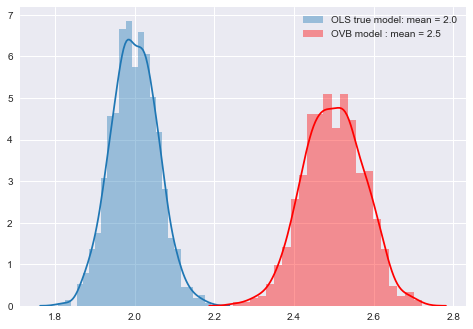

In [70]:
sns.distplot(beta_ols, color="#1f77b4",
             label = 'OLS true model: mean = {}'.format(round(np.mean(beta_ols), 2)))
sns.distplot(beta_ovb, color="r",
             label = 'OVB model : mean = {}'.format(round(np.mean(beta_ovb), 2)))
plt.legend();

### Omitted variableと相関していない場合

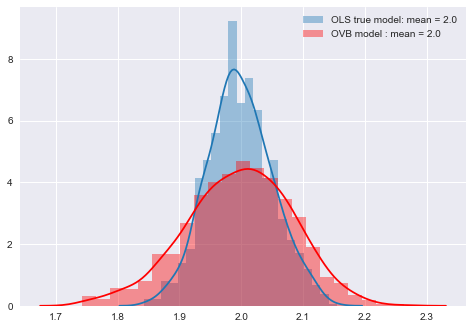

In [71]:
beta_ols, beta_ovb = simulation(cov_matrix = np.array([[2, 0], [0, 2]]), trial = 1000)
sns.distplot(beta_ols, color="#1f77b4",
             label = 'OLS true model: mean = {}'.format(round(np.mean(beta_ols), 2)))
sns.distplot(beta_ovb, color="r",
             label = 'OVB model : mean = {}'.format(round(np.mean(beta_ovb), 2)))
plt.legend();

### OVBとconsistent estimatorの関係

$$
\text{plim } \hat\beta_{1OVB} = \beta_1 + \beta_2\frac{cov(\tilde x_1, x_2)}{var(x_i)}
$$

この公式より、OVBの方向性と程度がどのように決まっているか知る事ができる。

- $\tilde x_1$: the residual from regressiong $x_1$ on other covariates except the outcome
- $\beta_2 > 0$: biasはpositive
- $cov(x_1, x_2) = 0$ならばOVBは発生しない
- covariatesを入れる事でbiasの程度が抑えられる事がわかる


### Proxy Variable

Proxy Variableを用いる事でOVBを軽減することができる。Proxy variableの条件の1つとして、structual equationにおいてredundant (ignorable)でなければならない。つまり、$z$が$x_2$のproxy variableとして機能するためには、

$$
E[y|x_1, x_2, z] = E[y|x_1, x_2]
$$

が必要。もう一つの条件（必ずしも必要というわけではない）は、omitted variable, $x_2$と$x_1$のcorrelationは$z$をコントロールするとゼロになること。$L(\cdot|\cdot)$をLinear projectionとすると、

$$
L(x_2|1, x_1, z) = L(x_2|1, z)
$$



### Proxy variable simulation

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i
$$

$(\beta_0, \beta_1, \beta_2) = (1, 2, 1)$とする。また、$(x_1, z)$はi.i.d sampleで分布は以下のように設定する

$$
\left(\begin{array}{c}x_1\\z\end{array}\right) \sim N \left(
\left(\begin{array}{c}3\\4\end{array}\right) , \left(\begin{array}{cc}2&1\\1&2\end{array}\right) 
\right)
$$

$x_2$は以下のように生成されるとする

$$
x_{2} = 1 + \gamma z + v
$$



$\epsilon_i, v$もi.i.d from $N(0, 1)$, $\gamma = 2$とする。sample size = 200, 試行回数500で$\hat\beta_{1ols}$と$\hat\beta_{1ovb}$の分布を確かめる。


In [72]:
def generate_data_2():
    cov_matrix = np.array([[2, 1], [1, 2]])
    mu = np.array([3, 4])
    N = 200
    beta = np.array([2., 1.], dtype = np.float)
    
    X = np.random.default_rng().multivariate_normal(mean = mu,
                                                    cov = cov_matrix, size = N, 
                                                    method = 'cholesky')
    
    v = np.random.normal(0, 1, N)
    x2 = 1 + 2 * X[:, 1] + v
    
    X_2 = np.stack([X[:, 0], x2], axis = 1)
    
    error = np.random.normal(0, 1, N)
    y = X @ beta + error + 1
    
    return X, y

def reg_ols_proxy(y, X):
    X = sm.add_constant(X)
    reg_proxy = sm.OLS(y, X).fit()
    reg_ovb = sm.OLS(y, X[:, :-1]).fit()
    beta_proxy = reg_proxy.params[1]
    beta_ovb = reg_ovb.params[1]
    
    return beta_proxy, beta_ovb

def simulation_2(trial = 500):
    ols = []
    ovb = []
    
    for i in range(trial):
        X_1, y_1 = generate_data_2()
        beta_ols, beta_ovb = reg_ols_proxy(y = y_1, X = X_1)
        ols.append(beta_ols)
        ovb.append(beta_ovb)
        
    return ols, ovb
    

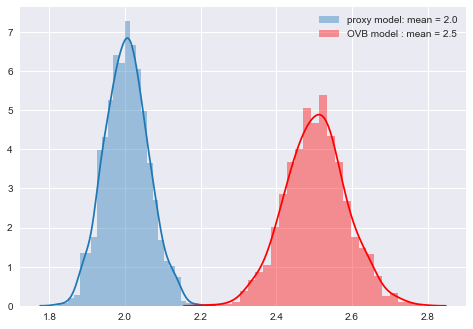

In [73]:
beta_ols, beta_ovb = simulation_2(trial = 1000)
sns.distplot(beta_ols, color="#1f77b4",
             label = 'proxy model: mean = {}'.format(round(np.mean(beta_ols), 2)))
sns.distplot(beta_ovb, color="r",
             label = 'OVB model : mean = {}'.format(round(np.mean(beta_ovb), 2)))
plt.legend();

### The lag variableとproxy variable

一期前のoutcome variableはproxy variableとして使える時がある。黒Wooldridge(P70)の`JTRAIN1.RAW`を用いて、job trainingの実施がscrap rateに与える影響を検証する。仮説として、job trainingはscrap rateを下げると考えている。ただし、job trainingは生産性が低い企業で実施される。

$$
\log(scrap)_{88} =  \beta_0 + \beta_1\text{grant} + \gamma q + \nu
$$

- q: unobservable, might be correlated with grant

ここで前年のscrap rateをproxy variableとして用いる。

$$
q = \theta_0 + \theta_1 \log(scrap_{-1}) + r
$$

- rがgrantとuncorrelatedである場合理想的なproxy variableとなる


#### dataの読み込み

In [74]:
df = pd.read_stata('https://www.stata.com/data/jwooldridge/eacsap/jtrain1.dta')
df.head()

,year,fcode,employ,sales,avgsal,scrap,rework,tothrs,union,grant,...,grant_1,clscrap,cgrant,clemploy,clsales,lavgsal,clavgsal,cgrant_1,chrsemp,clhrsemp
0,1987,410032.0,100.0,47000000.0,35000.0,NaN,NaN,12.0,0,0,...,0,NaN,0,NaN,NaN,10.463103,NaN,NaN,NaN,NaN
1,1988,410032.0,131.0,43000000.0,37000.0,NaN,NaN,8.0,0,0,...,0,NaN,0,0.270027,-0.088949,10.518673,0.055570,0.0,-8.946565,-1.165385
2,1989,410032.0,123.0,49000000.0,39000.0,NaN,NaN,8.0,0,0,...,0,NaN,0,-0.063013,0.130621,10.571317,0.052644,0.0,0.198597,0.047832
3,1987,410440.0,12.0,1560000.0,10500.0,NaN,NaN,12.0,0,0,...,0,NaN,0,NaN,NaN,9.259130,NaN,NaN,NaN,NaN
4,1988,410440.0,13.0,1970000.0,11000.0,NaN,NaN,12.0,0,0,...,0,NaN,0,0.080043,0.233347,9.305651,0.046520,0.0,0.000000,0.000000


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 0 to 470
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      471 non-null    int16  
 1   fcode     471 non-null    float32
 2   employ    440 non-null    float64
 3   sales     373 non-null    float32
 4   avgsal    406 non-null    float32
 5   scrap     162 non-null    float32
 6   rework    123 non-null    float32
 7   tothrs    415 non-null    float64
 8   union     471 non-null    int8   
 9   grant     471 non-null    int8   
 10  d89       471 non-null    int8   
 11  d88       471 non-null    int8   
 12  totrain   465 non-null    float64
 13  hrsemp    390 non-null    float32
 14  lscrap    162 non-null    float32
 15  lemploy   440 non-null    float32
 16  lsales    373 non-null    float32
 17  lrework   121 non-null    float32
 18  lhrsemp   390 non-null    float32
 19  lscrap_1  108 non-null    float32
 20  grant_1   471 non-null    int8  

In [76]:
reg_df = df.loc[:, ['year','fcode', 'scrap', 'd88', 'd89', 'lscrap', 'grant_1', 'grant', 'union']]
reg_df = reg_df.dropna().reset_index(drop = True)

In [77]:
col_info = {"year":np.int,
           "fcode":np.int}
reg_df = reg_df.astype(col_info)

In [78]:
reg_df.head()

,year,fcode,scrap,d88,d89,lscrap,grant_1,grant,union
0,1987,410523,0.06,0,0,-2.813411,0,0,0
1,1988,410523,0.05,1,0,-2.995732,0,0,0
2,1989,410523,0.05,0,1,-2.995732,0,0,0
3,1987,410538,2.64,0,0,0.970779,0,0,1
4,1988,410538,2.74,1,0,1.007958,0,0,1


#### lag variableの取得

In [79]:
shift_res = reg_df.groupby('fcode').apply(lambda x: x.sort_values(by = 'year'
                                                         , axis = 0,
                                                         inplace = False))
shift_res['before_scrap'] = shift_res['lscrap'].shift(periods = 1) 
shift_res = shift_res.reset_index(drop = True)
shift_res.head()

,year,fcode,scrap,d88,d89,lscrap,grant_1,grant,union,before_scrap
0,1987,410523,0.06,0,0,-2.813411,0,0,0,NaN
1,1988,410523,0.05,1,0,-2.995732,0,0,0,-2.813411
2,1989,410523,0.05,0,1,-2.995732,0,0,0,-2.995732
3,1987,410538,2.64,0,0,0.970779,0,0,1,-2.995732
4,1988,410538,2.74,1,0,1.007958,0,0,1,0.970779


#### regression dataをyear = 1988に限定する

In [80]:
isyear = shift_res['year'] == 1988
reg_df = shift_res.loc[isyear, :]
reg_df.head()

,year,fcode,scrap,d88,d89,lscrap,grant_1,grant,union,before_scrap
1,1988,410523,0.05,1,0,-2.995732,0,0,0,-2.813411
4,1988,410538,2.74,1,0,1.007958,0,0,1,0.970779
7,1988,410563,7.00,1,0,1.945910,0,0,1,1.791759
10,1988,410565,11.00,1,0,2.397895,0,0,1,3.044523
13,1988,410566,5.00,1,0,1.609438,0,0,0,1.945910


#### Regression

In [81]:
y, X = dmatrices('lscrap ~ grant',
                 data = reg_df,
                 return_type = 'dataframe')
results_1 = sm.OLS(y, X).fit(cov_type = 'HC0')

y, X = dmatrices('lscrap ~ grant + before_scrap',
                 data = reg_df,
                 return_type = 'dataframe')
results_2 = sm.OLS(y, X).fit(cov_type = 'HC0')

In [82]:
results = [results_1, results_2]
reg_names = ['without proxy model', 'with proxy model']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'grant',
                   'before_scrap']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Effects of Job Training Grants on Worker Productivity')
print(results_table)

Effects of Job Training Grants on Worker Productivity
                 without proxy model with proxy model
-----------------------------------------------------
Intercept        0.409               0.021           
                 (0.258)             (0.097)         
grant            0.057               -0.254*         
                 (0.364)             (0.142)         
before_scrap                         0.831***        
                                     (0.071)         
R-squared        -0.019              0.868           
                 0.000               0.873           
Pseudo R-squared                                     
No. observations 54                  54              
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


よって、grantによって

$$
100\times [\exp(-0.254) - 1] = -22.4\%
$$

のscrap rate改善インパクトがあると解釈できる。

### REMARKS

- omitted variableと相関していないproxy variableを用いるとbiasの程度が酷くなることに留意が必要
- FWL定理より明らか



## 7. Bad Control: Post Treatment Bias

Bad ControlsとはRCTのtreatment assignmentの結果定まる変数のこと。Good Controlsとは実験まえにすでにFixedされている変数のこと。

### Bad Controlとselection bias

ここで学位授与がランダムに割り当てられる世界を考える。そして、Research Questionは学位の有無が賃金に与える影響を評価したいとする。

- $Y_i$: wage
- $C_i$: 学位の有無

この時、回帰分析において職業（ホワイトカラー）, $W_i$, のコントロールもしたいと考えたとする。そして、ホワイトカラーか否かは賃金に影響を与えるし、また学位の有無はホワイトカラーか否かに影響を与えるとする。

つまり、Causal Graphとして書くと、

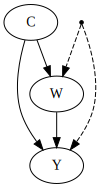

In [83]:
bad_control = CausalGraphicalModel(
    nodes=["C", "W", "Y"],
    edges=[
        ("C", "Y"), 
        ("C", "W"),
        ("W", "Y")
    ],
    latent_edges=[
        ("Y", "W")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
bad_control.draw()

これでは$C_i$の$Y_i$に対する影響を分析する事ができない。

$$
\begin{aligned}
Y_i & = C_iY_{1i} + (1 - C_i)Y_{0i}\\
W_i & = C_iW_{1i} + (1 - C_i)W_{0i}
\end{aligned}
$$

もちろん、以下は推定できる

$$
\begin{aligned}
E[Y_i|C_i = 1] - E[Y_i|C_i = 0] &= E[Y_{1i} - Y_{0i}]\\
E[W_i|C_i = 1] - E[W_i|C_i = 0] &= E[W_{1i} - W_{0i}]
\end{aligned}
$$

一方、

$$
\begin{aligned}
E[Y_i|W_i = 1, C_i = 1] - E[Y_i|W_i = 1, C_i = 0] & = E[Y_{1i}|W_i = 1, C_i = 1] - E[Y_{0i}|W_i = 1, C_i = 0]\\
& = E[Y_{1i}|W_{1i} = 1] - E[Y_{0i}|W_{0i} = 1]\\
& = E[Y_{1i} - Y_{0i}|W_{1i} = 1] + E[Y_{0i}|W_{1i} = 1] - E[Y_{0i}|W_{0i} = 1]
\end{aligned}
$$

よってselection biasが発生する。


### simulation

In [84]:
def generate_data_3(true_effect = 2.0):
    N = 200
    C = np.random.choice(2, N, p=[0.5, 0.5])
    error = np.random.normal(0, 1, N)
    v = np.random.normal(0, 1, N)
    Z = 0.3 + 0.2*C + error
    Y = 0.2 + (true_effect/0.2)*Z + v
    X = np.stack([C, Z], axis =1)

    return X, Y

def reg_ols_bad_control(y, X):
    X = sm.add_constant(X)
    reg_bad = sm.OLS(y, X).fit()
    reg_true = sm.OLS(y, X[:, :-1]).fit()
    beta_bad = reg_bad.params[1]
    beta_true = reg_true.params[1]
    
    return beta_bad, beta_true

def simulation_3(trial = 500):
    true = []
    bad = []
    
    for i in range(trial):
        X_1, y_1 = generate_data_3()
        beta_bad, beta_true = reg_ols_bad_control(y = y_1, X = X_1)
        bad.append(beta_bad)
        true.append(beta_true)
        
    return true, bad
    

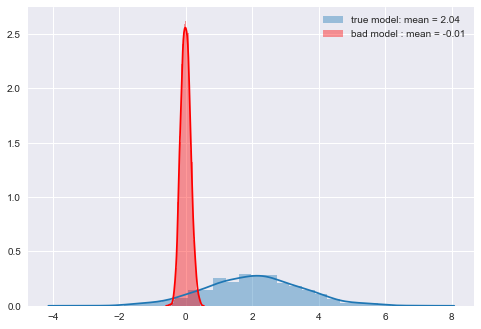

In [85]:
beta_true, beta_bad = simulation_3(trial = 1000)
sns.distplot(beta_true, color="#1f77b4",
             label = 'true model: mean = {}'.format(round(np.mean(beta_true), 2)))
sns.distplot(beta_bad, color="r",
             label = 'bad model : mean = {}'.format(round(np.mean(beta_bad), 2)))
plt.legend();

## 8. 回帰分析を利用した探索的な効果検証（Angrist et al. (2002)）
### 論文概要

コロンビアで私立学校（中学高校）に通っており、かつ成績が良い生徒に対してランダムに学費の割引券を付与した(PACES program)。ランダム割り当ての3年後、割引券付与者は8th gradeを完了している割合が比較群に対して10 ppt高かった。テストスコアも0.2 standard deviations高い傾向が見られた。また、十代での結婚率や十代での労働時間に対してもそれらを低減する影響が見られた。

### Background

教育に対して補助を行うときに、教育を提供する側に援助を行うべきか？、教育の受給者に対して補助を行うべきか？という議論がある。

### Research Question

- Voucherのschool outcomeとschool choiceへの影響
- voucherのtest scoreとnoneducation outcomeへの影響
- 2SLSを用いたschool scholarshipのeducational/noneducational outcomeへの影響
- Voucher programのcost benefit analysis

### PACES programの概要

- 1991年に成立、World Bankがファイナンスのサポート
- secondary-school enrollment ratesを上昇させることを目的としている(1993年でeligile ageの子供のうち55%のみがsecondary-schoolに通っている)
- low-income familiesをtarget(書類を提出する必要がある)
- 授業料の半額程度を割り引いてくれる
- 受給資格を得たとしても生徒が留年すると、その資格はなくなる

### PACES programの期待される効果

- 授業料が下がることによって質の高い教育を受ける（私立学校）割合が高まる
- 落第すると受給資格を失うので、生徒に努力するインセンティブが発生する。留年の減少、テストスコアの上昇という効果が期待される

### Data

- 対象：1993, 1995, 1996, 1997のcohortに対して1998年にインタビュー
- 集計方法：電話(申請者のうち80 ~ 88%の家庭が保有)
- response rate: 54 ~ 61%

#### Remarks

- Data Generating Processより電話へのアクセスがある家庭に絞られる
- response rateにはtreatment statusの影響は見られなかった


### READ data

- `VOUCH0`: voucherの付与の有無
- `BOG95SMP', 'BOG97SMP', 'JAM93SMP'`: cohort


In [86]:
import rdata
import warnings

In [87]:
warnings.resetwarnings()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    path = './data/vouchers.rda'
    parsed = rdata.parser.parse_file(path)
    converted = rdata.conversion.convert(parsed)
    df = pd.DataFrame(converted['vouchers'])
df.head()

,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,INSCHL,...,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,1.0,NaN,12.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,0.0,0.0,0.0,0.0,NaN,13.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,4.0,1.0,0.0,0.0,1.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


### Covariatesとvoucher statusの関係の調査

cohort別のInterviewに回答した人数とtreatment statusの割合

In [88]:
df.groupby(['BOG95SMP', 'BOG97SMP', 'JAM93SMP'])['VOUCH0'].agg(['count', 'mean']).iloc[1:, :].T

BOG95SMP         0.0                      1.0
BOG97SMP         0.0         1.0          0.0
JAM93SMP         1.0         0.0          0.0
count     165.000000  277.000000  1176.000000
mean        0.551515    0.527076     0.504252

In [89]:
df.groupby(['BOG95SMP', 
            'BOG97SMP', 
            'JAM93SMP'])[['SEX', 'AGE','AGE2',
                          'FINISH6', 'FINISH7',
                          'SCYFNSH', 'INSCHL']].agg('mean').iloc[1:, :].T

BOG95SMP        0.0                   1.0
BOG97SMP        0.0        1.0        0.0
JAM93SMP        1.0        0.0        0.0
SEX        0.424242   0.505415   0.500850
AGE       16.914634  13.083333  15.004266
AGE2      12.490798  12.408088  12.593750
FINISH6    0.932927   0.916364   0.946200
FINISH7    0.920732   0.098182   0.859095
SCYFNSH    8.557576   6.025271   7.566327
INSCHL     0.777778   0.956522   0.835757

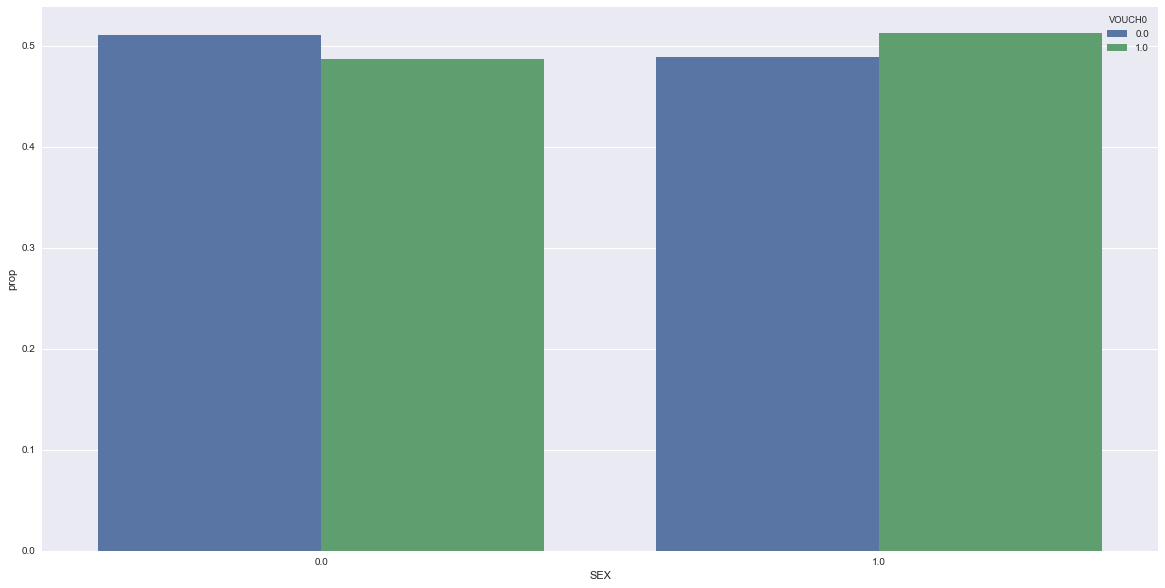

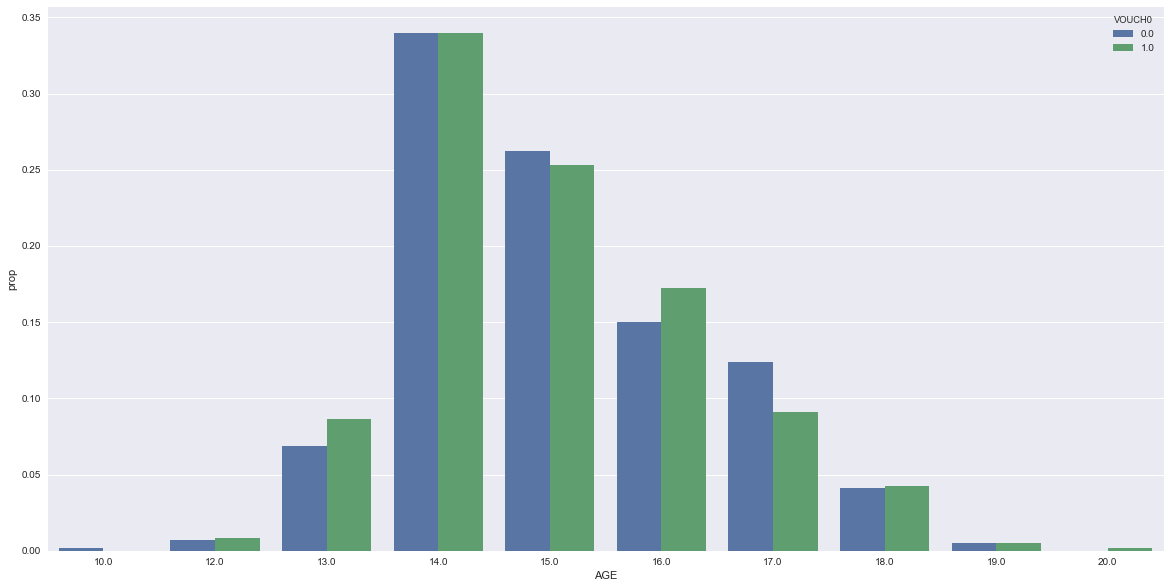

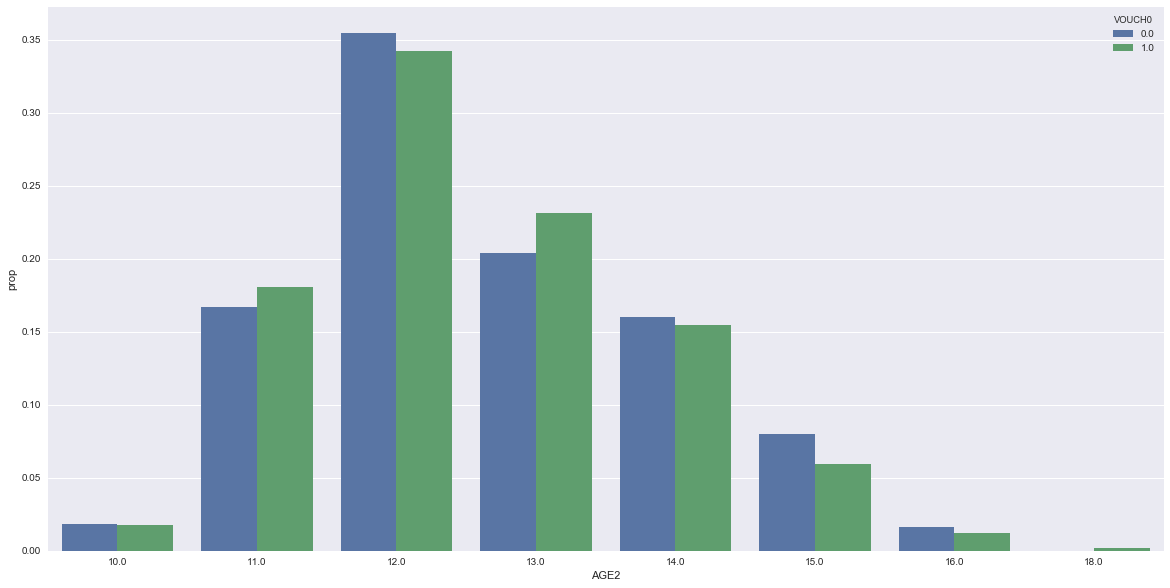

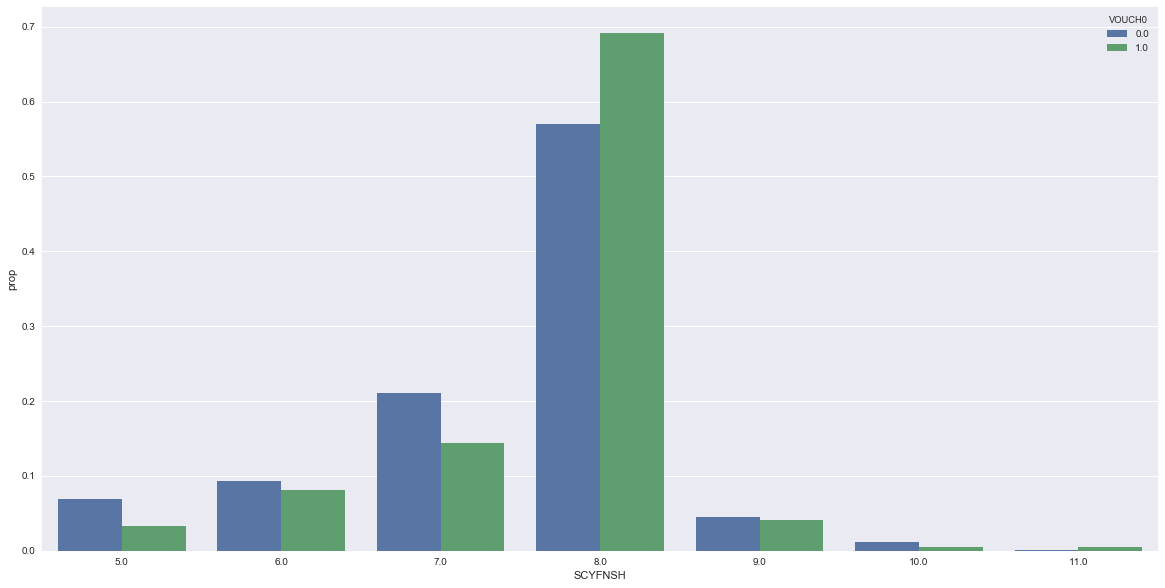

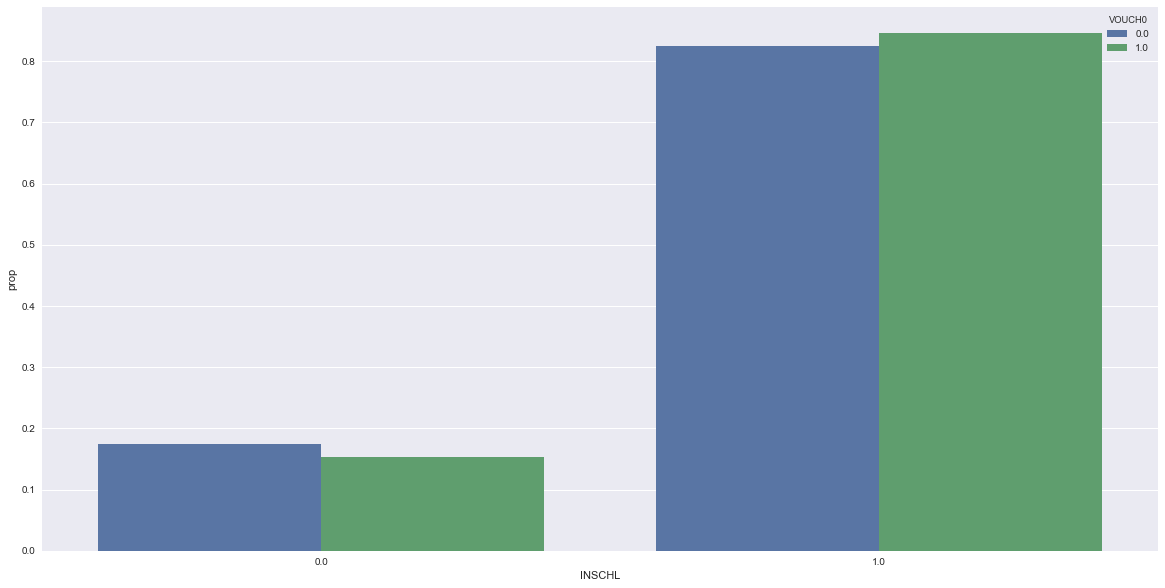

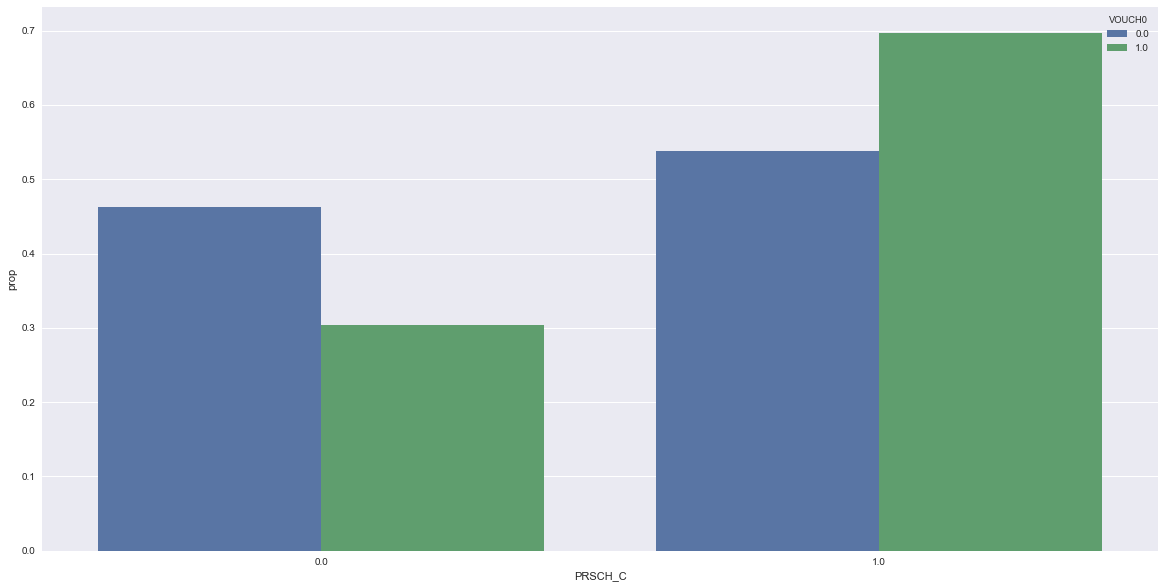

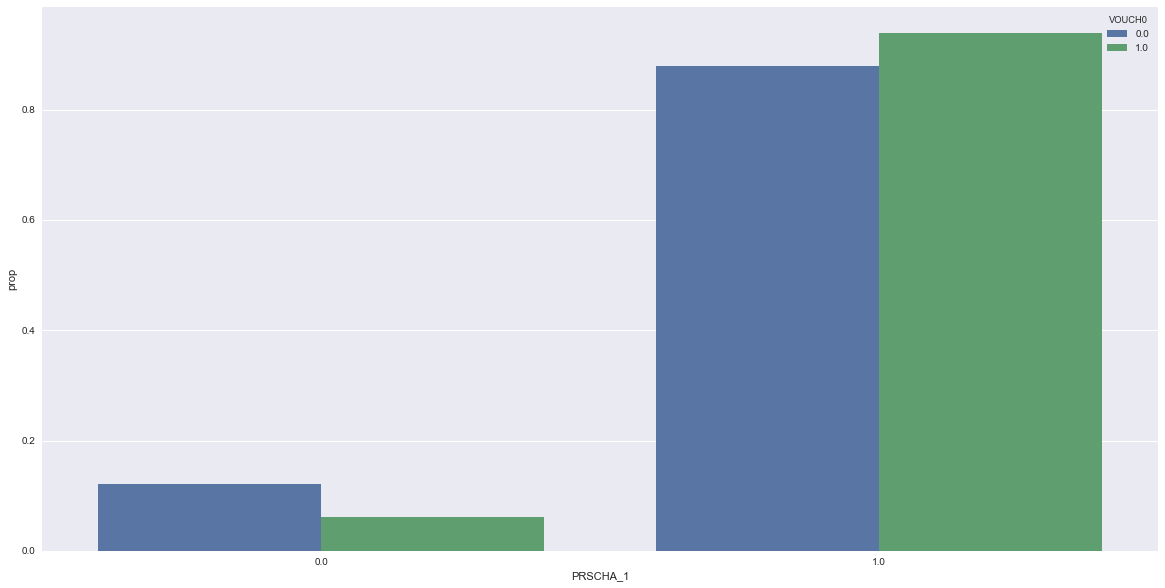

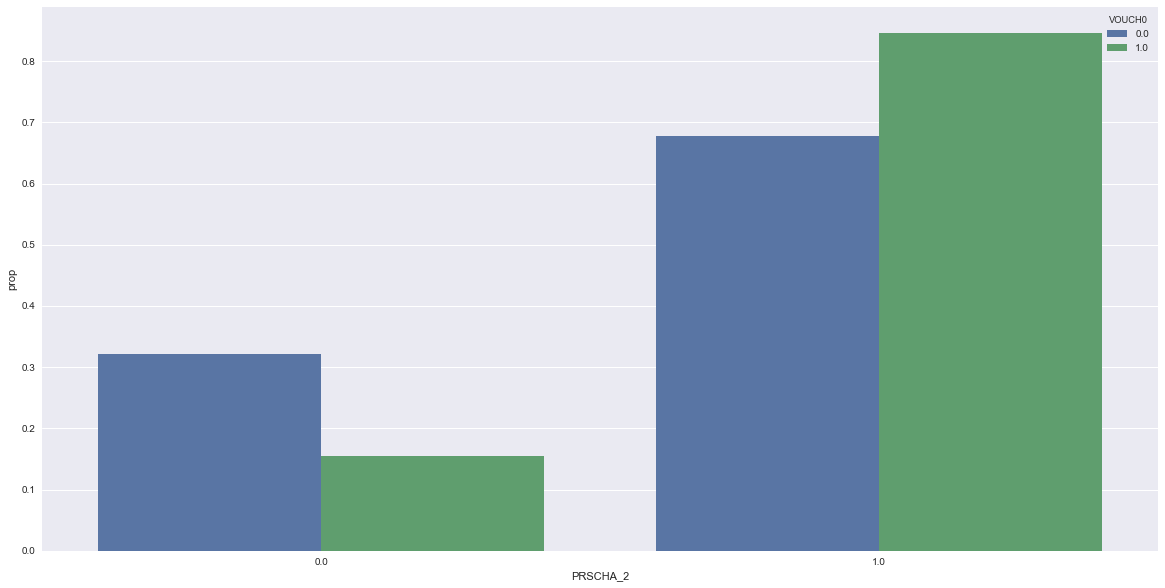

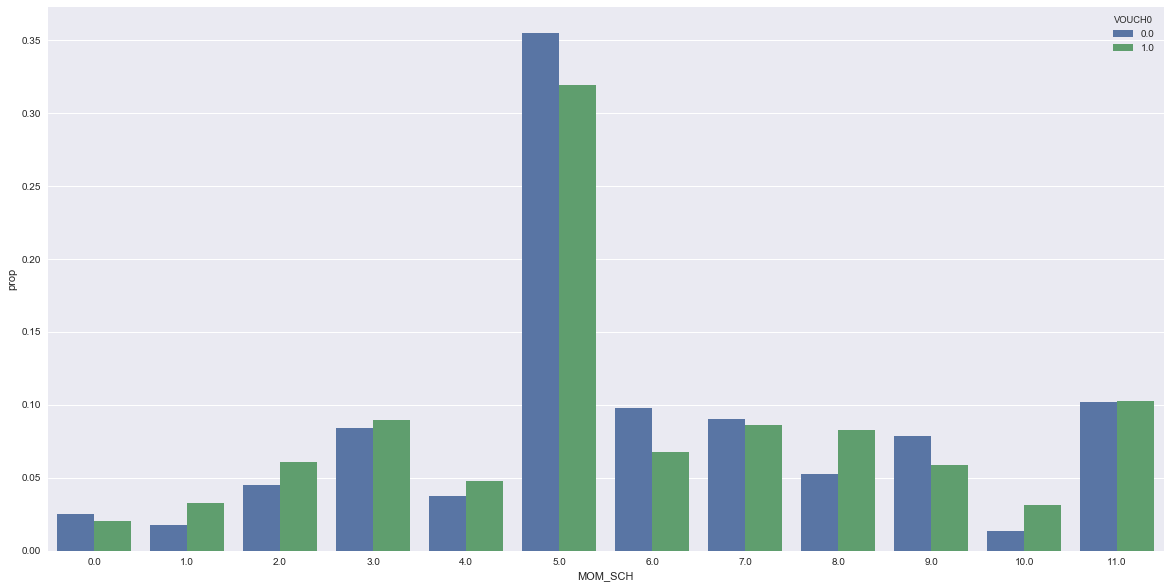

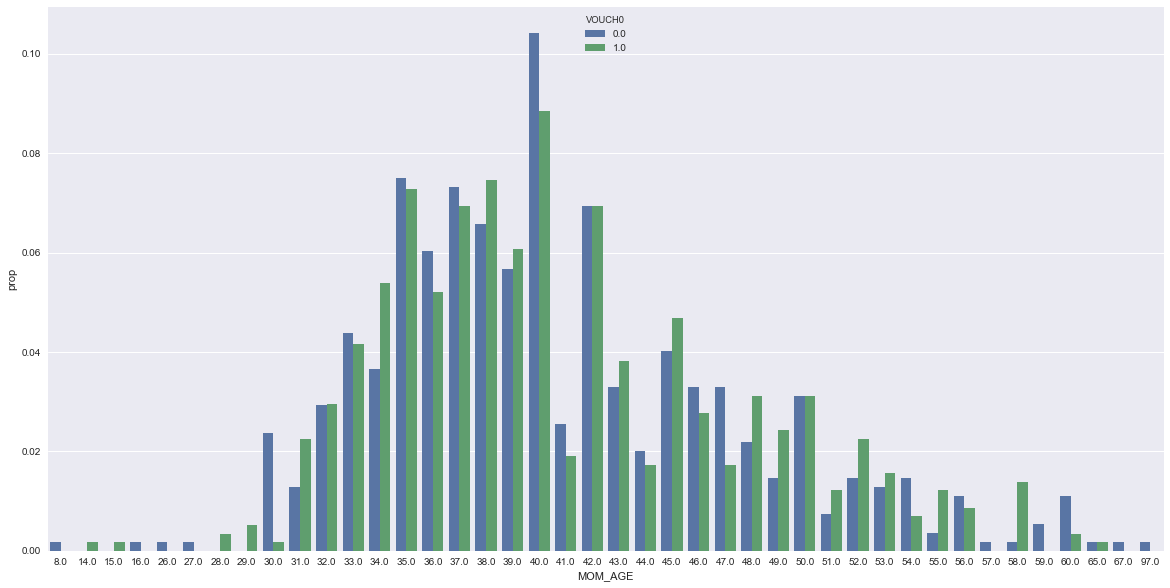

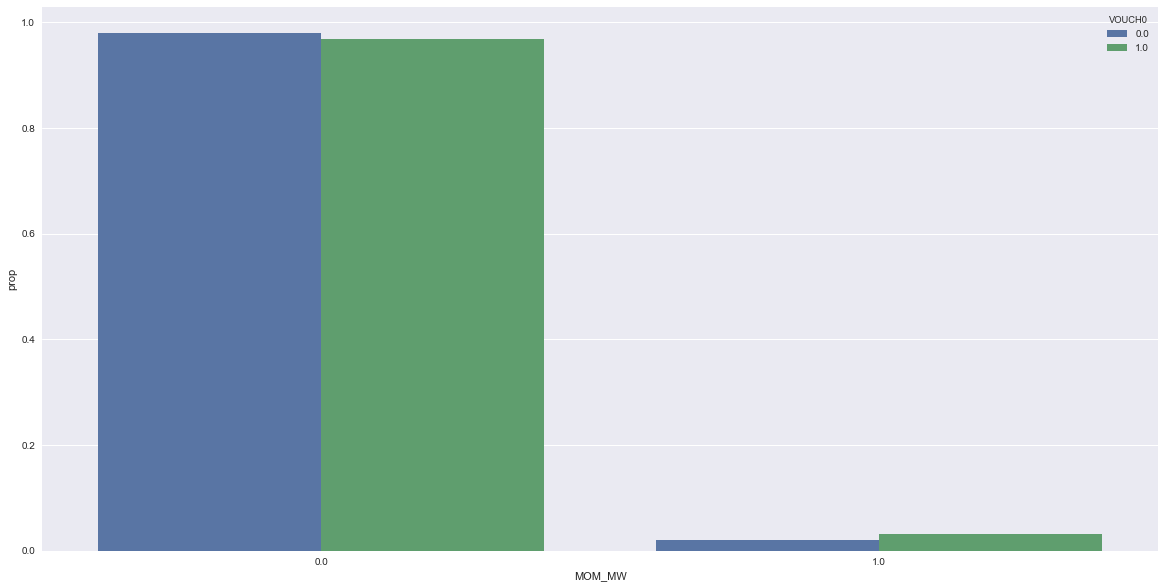

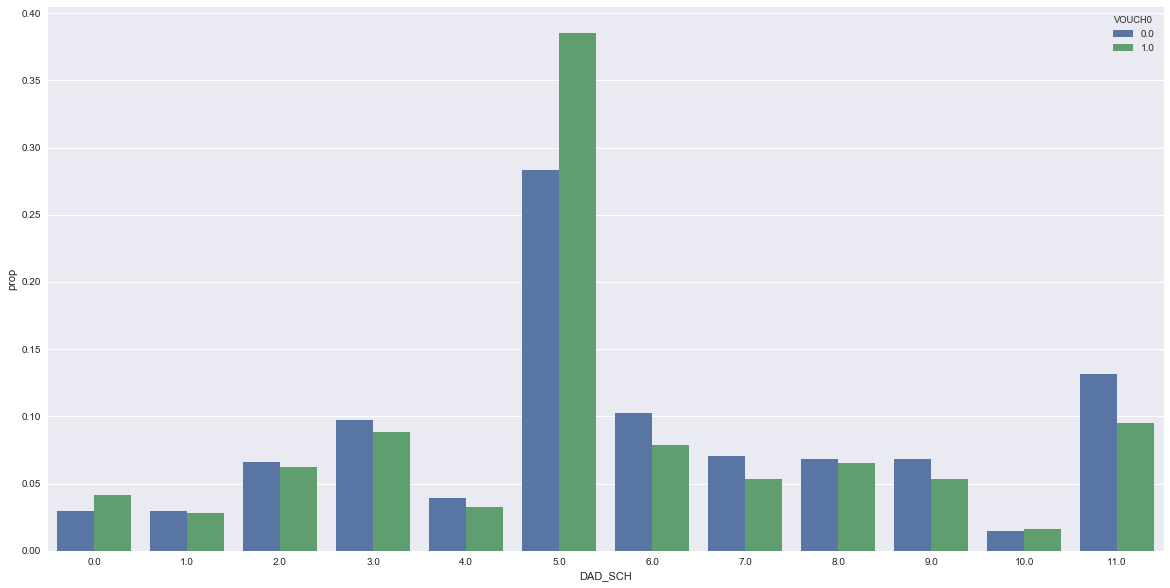

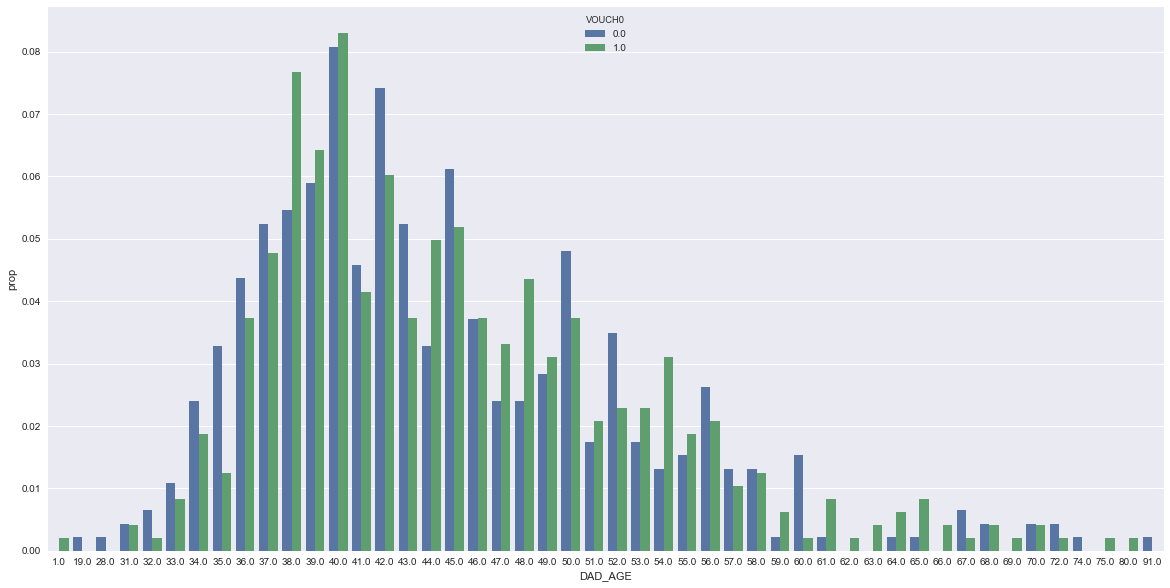

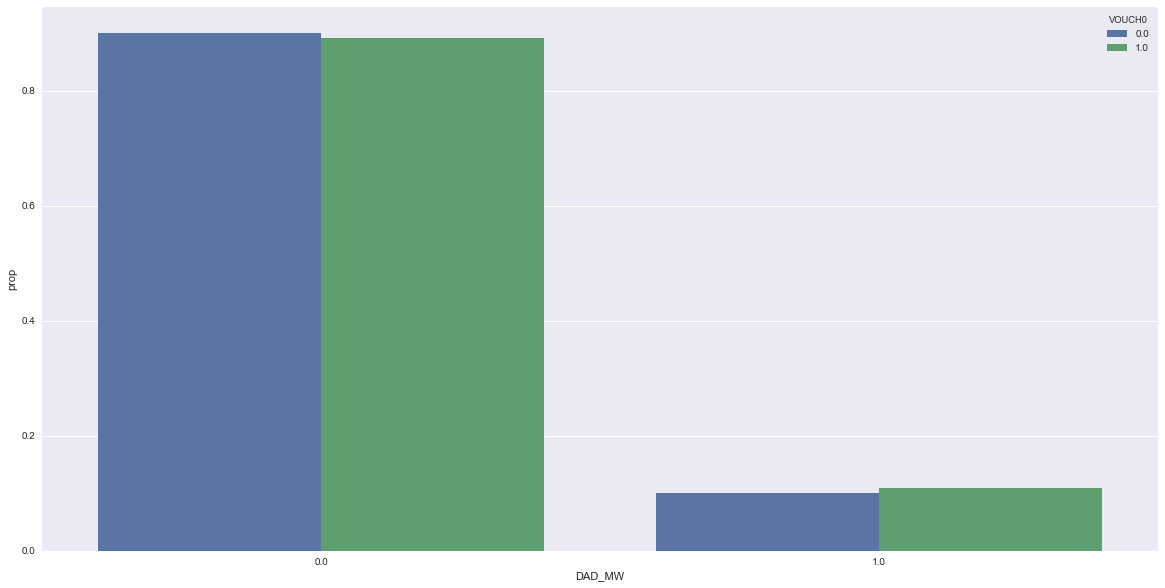

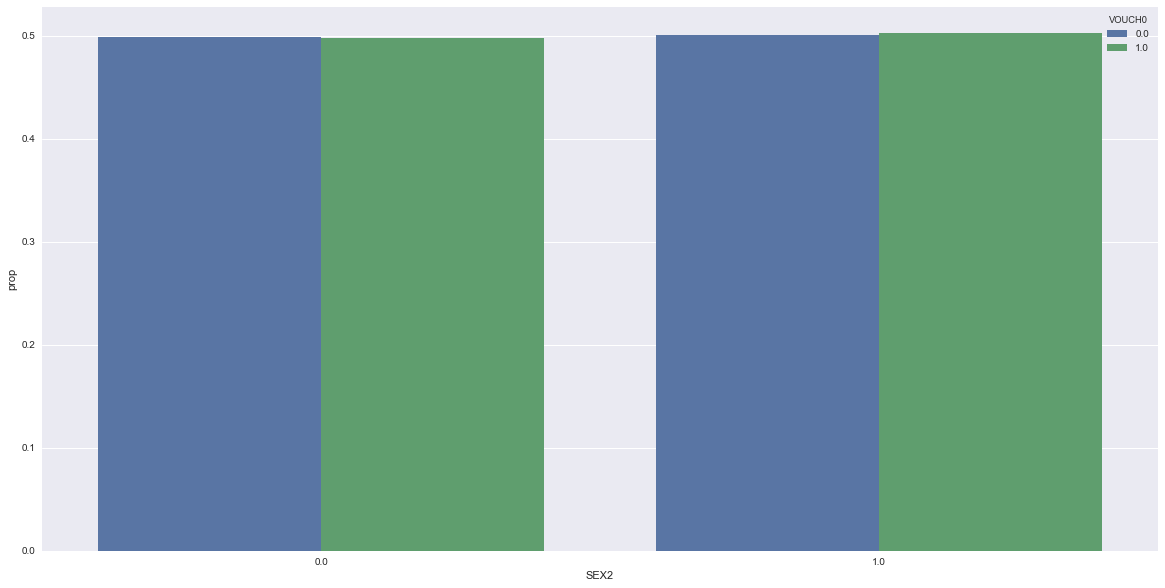

In [90]:
columns = ['SEX', 'AGE', 'AGE2','SCYFNSH', 'INSCHL', 'PRSCH_C', 'PRSCHA_1', 'PRSCHA_2',
        'MOM_SCH', 'MOM_AGE', 'MOM_MW', 'DAD_SCH',
       'DAD_AGE', 'DAD_MW', 'SEX2']
hue = 'VOUCH0'
y = 'prop'
is95 = df['BOG95SMP'] > 0
df_95 = df.loc[is95, :]

for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
        
        
    
    prop_df = (df_95.groupby(hue)[column]
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())
    
    sns.barplot(x=column, y=y, hue = hue, data=prop_df, ax=axs)

normalized differenceの確認

In [91]:
normed_diff = df_95.groupby('VOUCH0')[columns].agg(['mean', 'var'])
snd = compute_normed_diff(normed_diff, feature = columns)
snd

,features,snd
0,SEX,0.04757
1,AGE,0.04695
2,AGE2,0.04880
3,SCYFNSH,0.19826
4,INSCHL,0.05600
5,PRSCH_C,0.33146
6,PRSCHA_1,0.20840
7,PRSCHA_2,0.40069
8,MOM_SCH,0.01424
9,MOM_AGE,0.00550


### JAM93SMP Cohortの確認

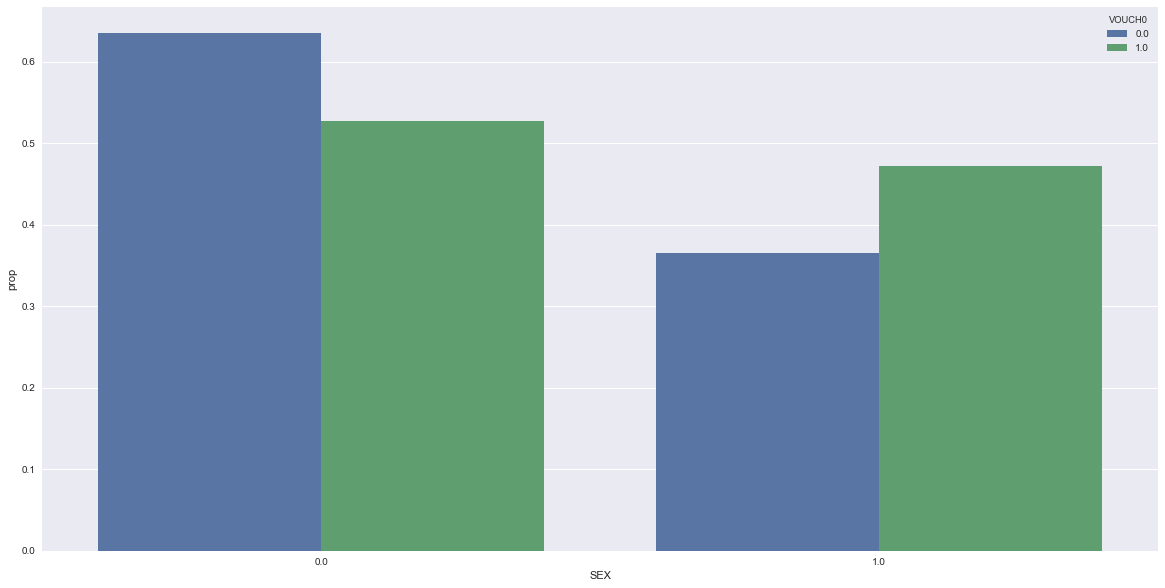

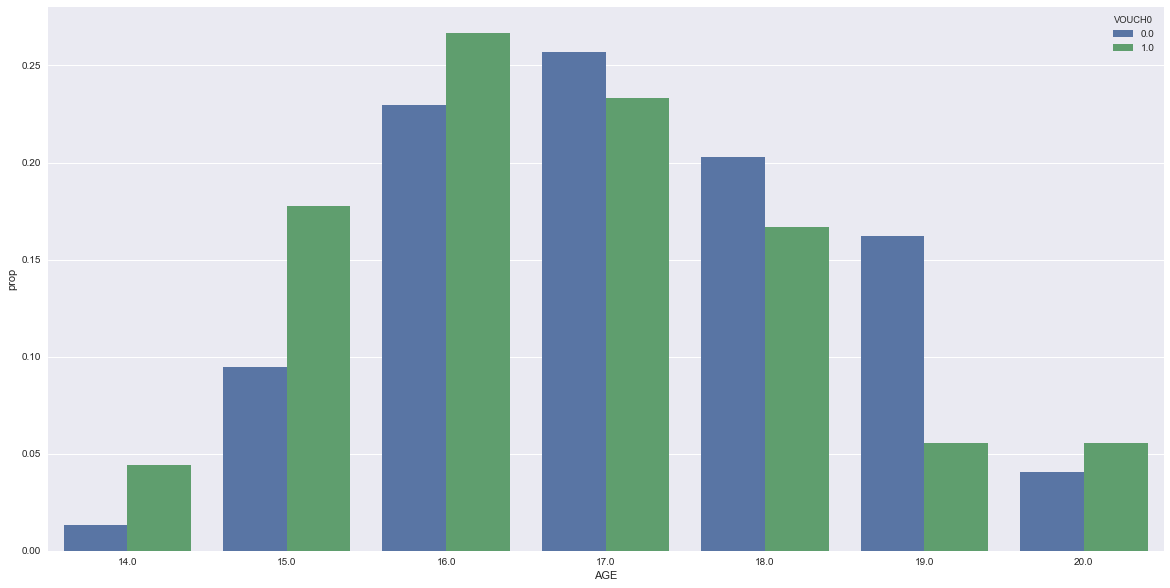

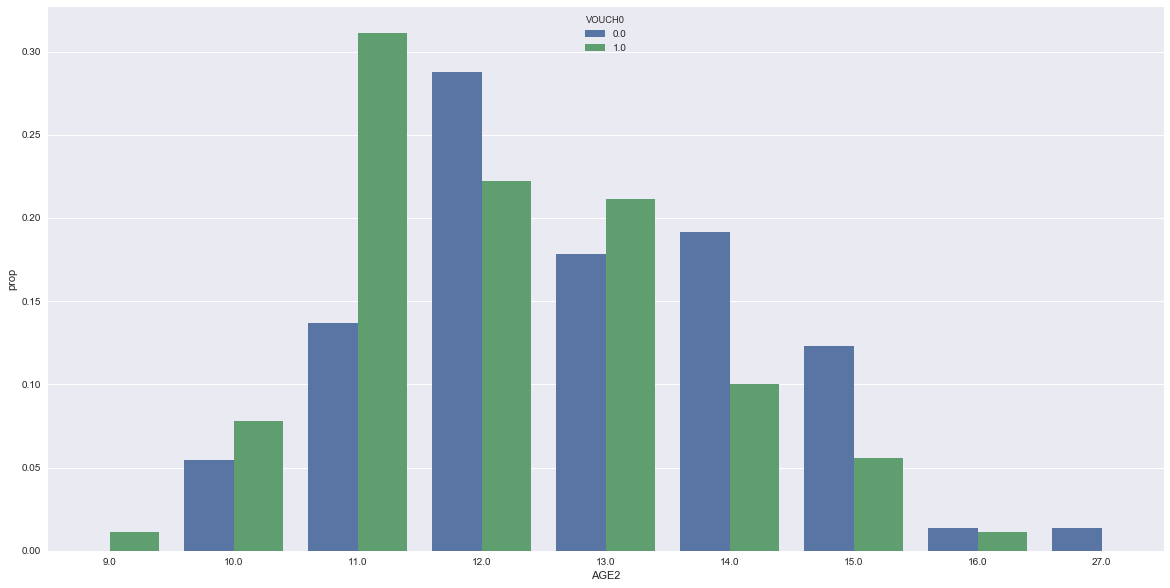

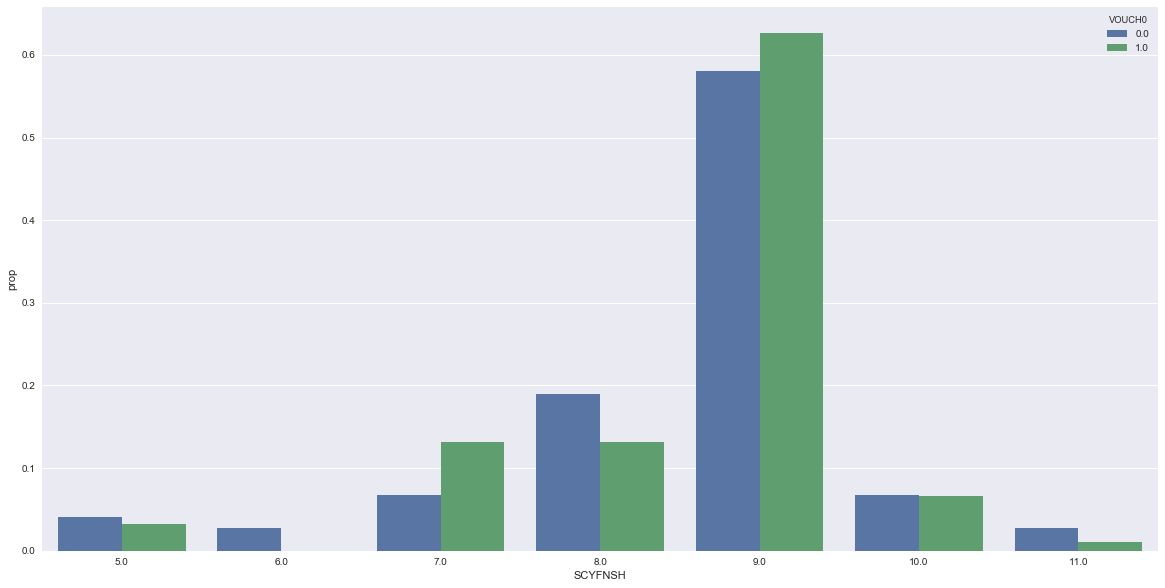

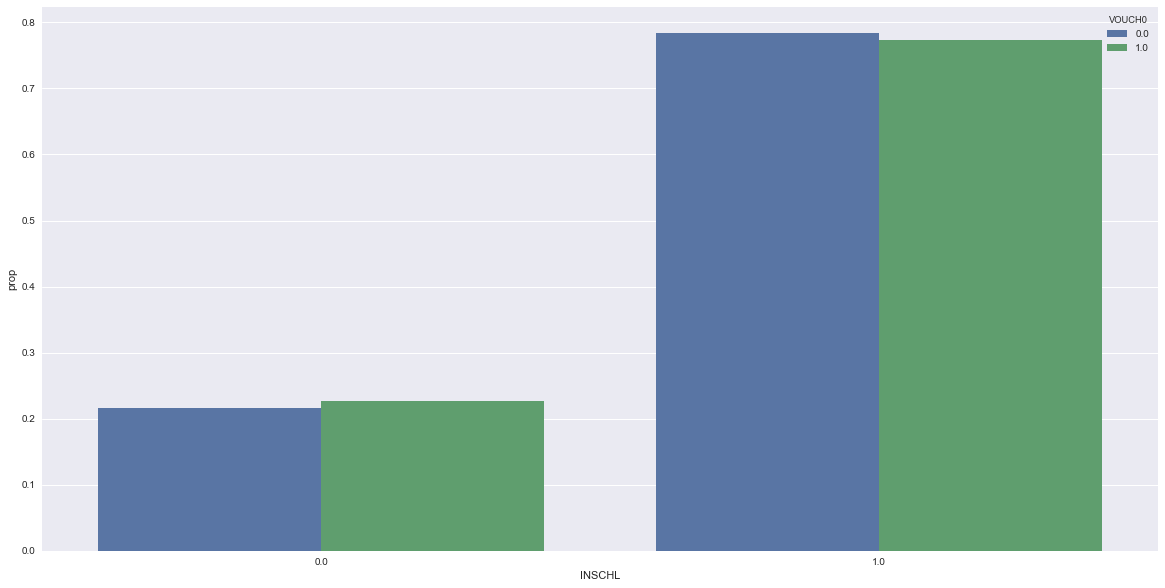

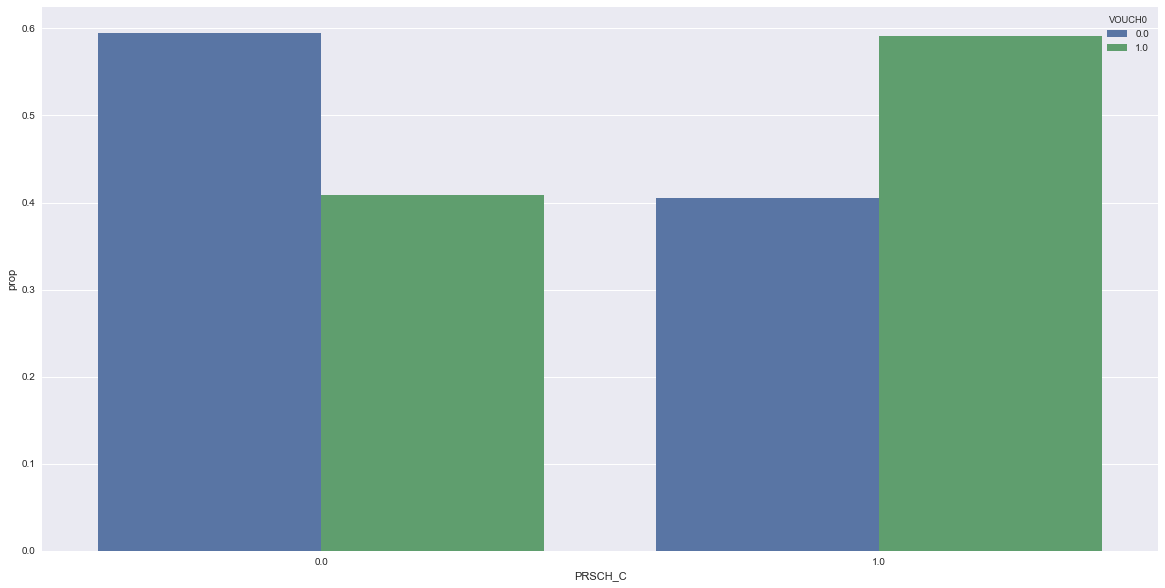

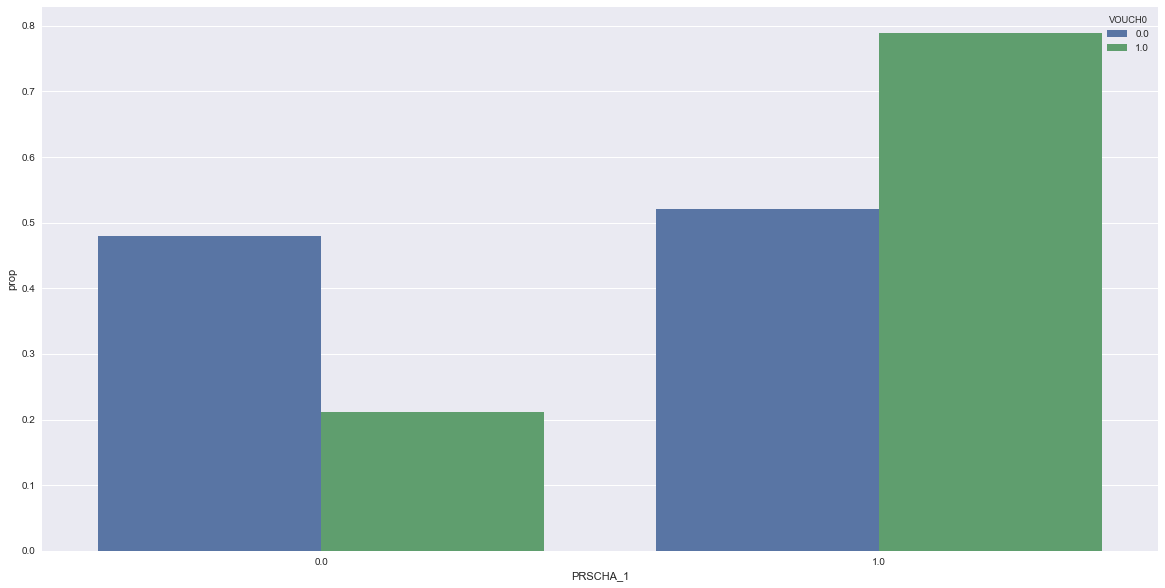

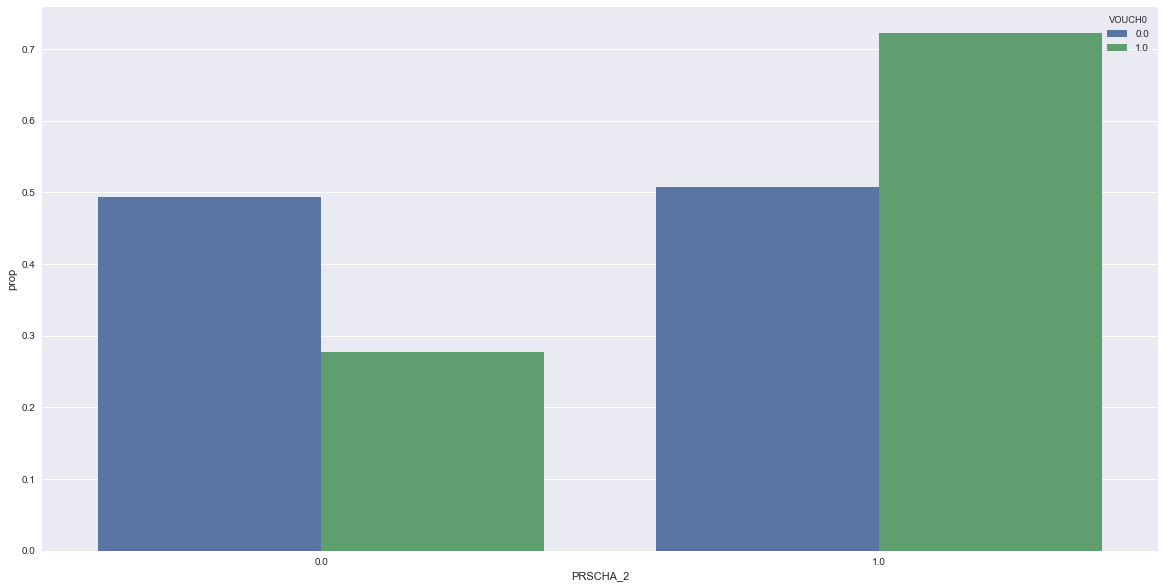

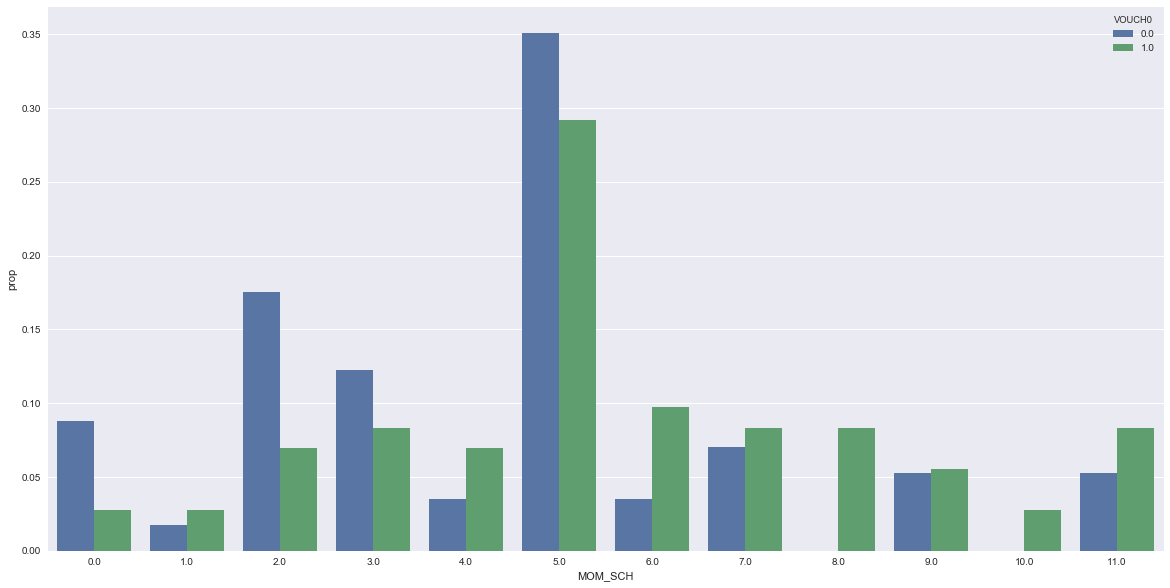

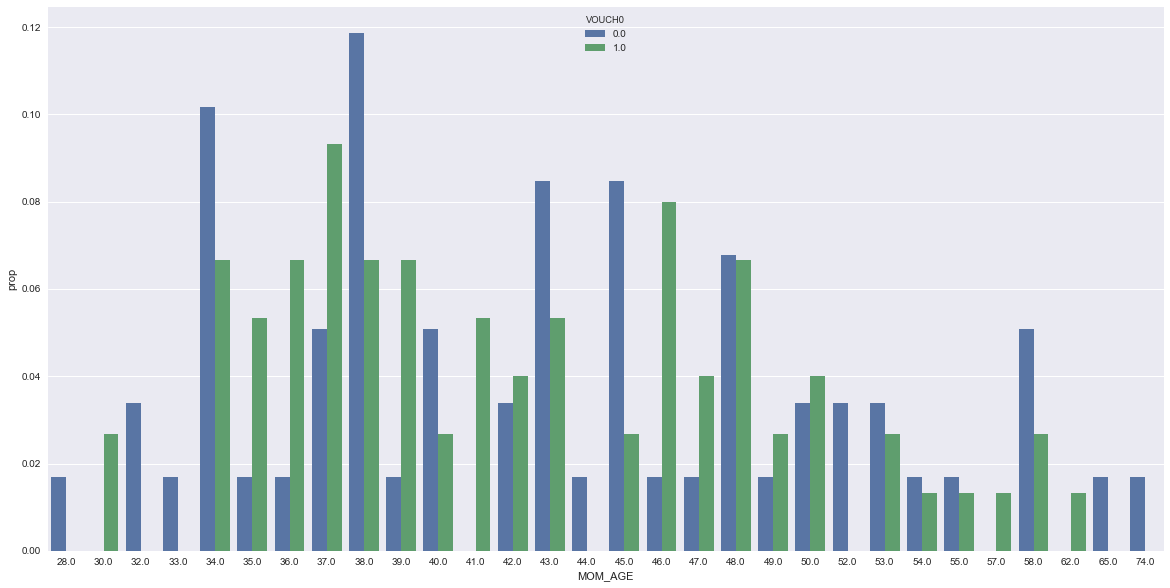

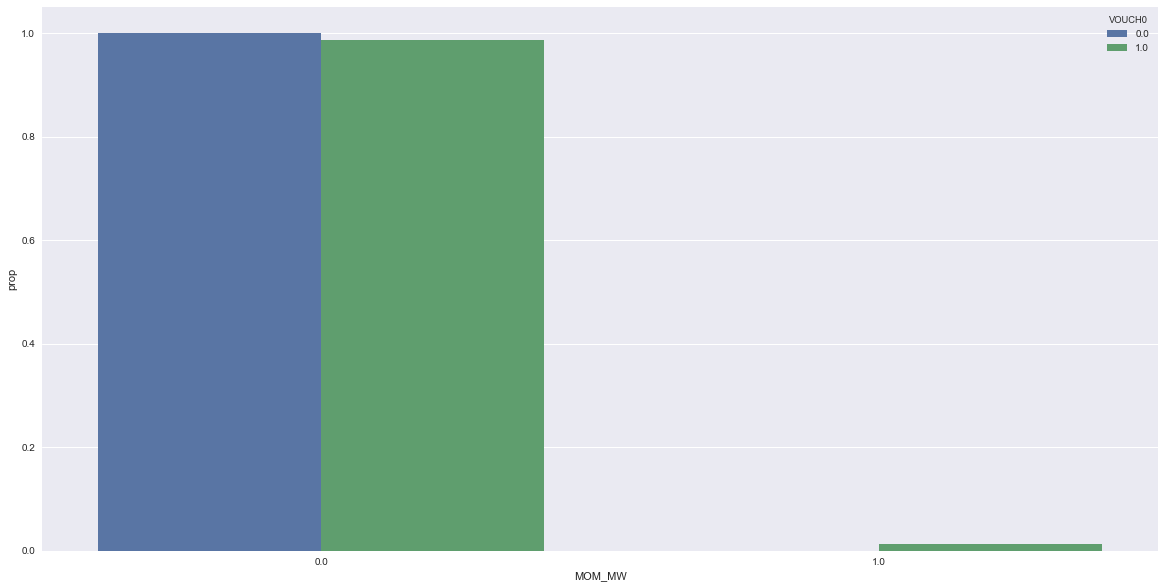

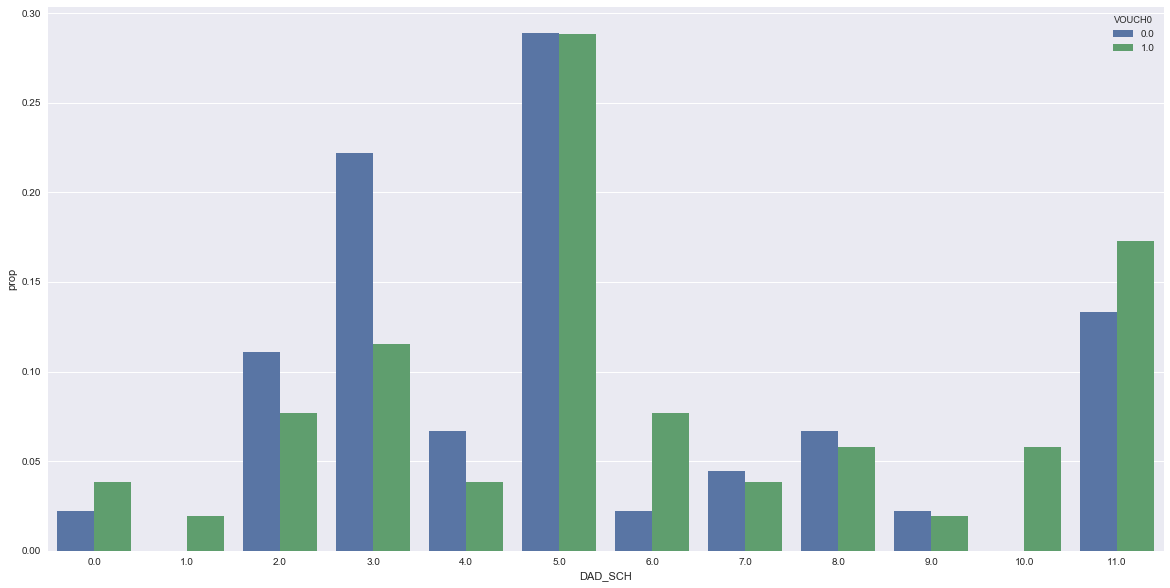

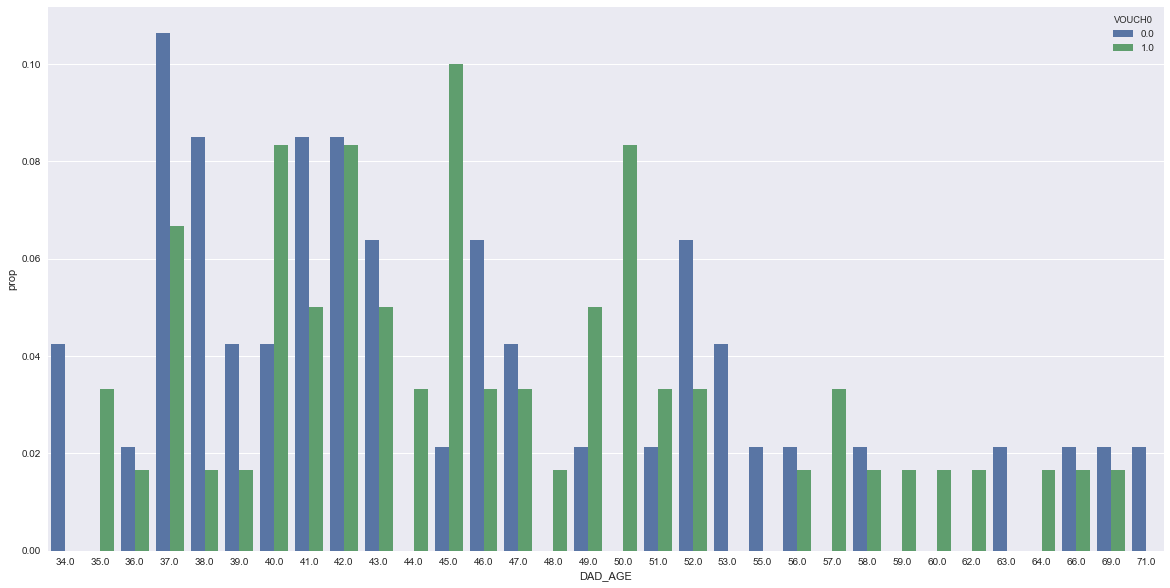

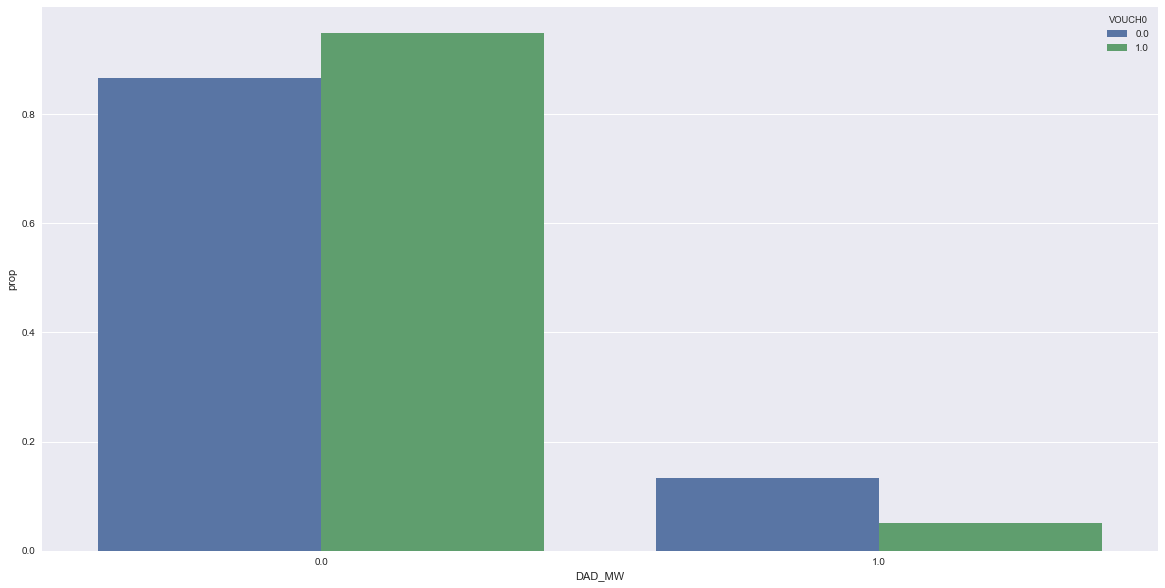

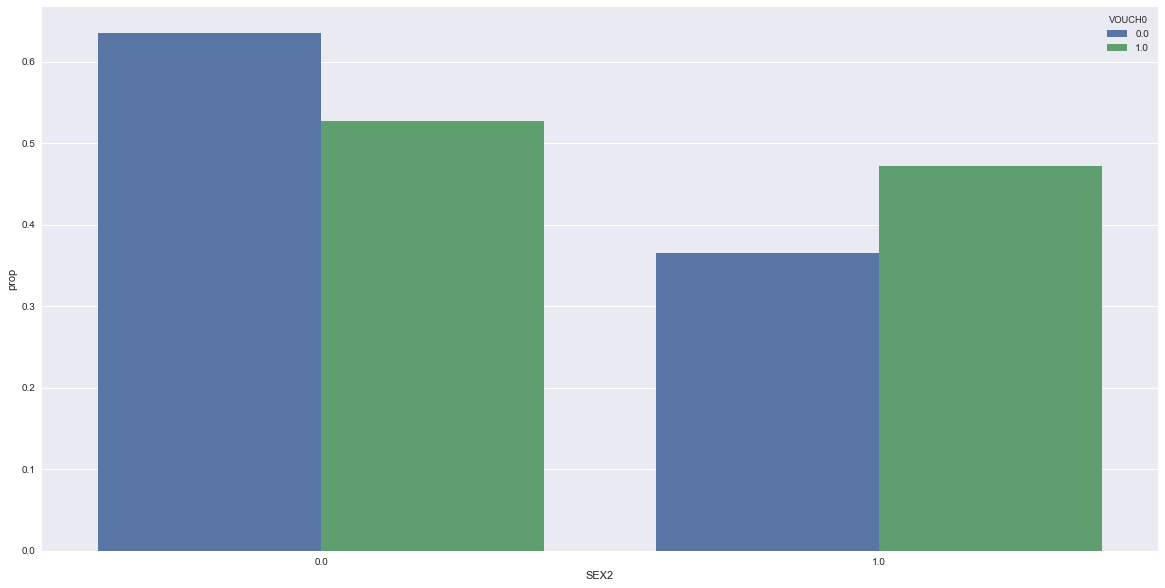

In [92]:
is93 = df['JAM93SMP'] > 0
df_93 = df.loc[is93, :]

for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
        
        
    
    prop_df = (df_93.groupby(hue)[column]
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())
    
    sns.barplot(x=column, y=y, hue = hue, data=prop_df, ax=axs)

normalized differnceの確認

In [93]:
normed_diff = df_93.groupby('VOUCH0')[columns].agg(['mean', 'var'])
snd = compute_normed_diff(normed_diff, feature = columns)
snd

,features,snd
0,SEX,0.21820
1,AGE,0.34813
2,AGE2,0.44294
3,SCYFNSH,0.00576
4,INSCHL,0.02645
5,PRSCH_C,0.37521
6,PRSCHA_1,0.58455
7,PRSCHA_2,0.45090
8,MOM_SCH,0.47340
9,MOM_AGE,0.14393


### REMARK

- `'JAM93SMP'`のデータはcovariatesの分布がtreated, controlで違いすぎるのでrandomではない割り当てを実施されたと解釈できる


### Impact on Scholarship Use, School Choice, and Schooling

$$
y_{ic} = \mathbb X_i'\mathbb\beta_0 + \alpha_0 Z_i + \delta_c + \epsilon_{ic}
$$

- i: individual
- c: cohort (defined by city and year)


#### bogota 1995の再現

In [94]:
x_covariate = ['SVY', 'HSVISIT', 'AGE',
               'STRATA1', 'STRATA2', 'STRATA3',
               'STRATA4', 'STRATA5', 'STRATA6', 
               'STRATAMS','D1993', 'D1995', 
               'D1997', 'DMONTH1', 'DMONTH2', 
               'DMONTH3', 'DMONTH4', 'DMONTH5', 
               'DMONTH6','DMONTH7', 'DMONTH8',
               'DMONTH9', 'DMONTH10', 'DMONTH11', 
               'DMONTH12', 'SEX2']

dependent = ["TOTSCYRS","INSCHL","PRSCH_C",
             "USNGSCH","PRSCHA_1","FINISH6",
             "FINISH7","FINISH8","REPT6",
             "REPT","NREPT","MARRIED",
             "HASCHILD","HOURSUM","WORKING3"]

In [95]:
covariates = ''
for i in range(len(x_covariate)):
    tmp = ' + ' + x_covariate[i]
    covariates += tmp
    
reg_names = []
for i in range(len(dependent)):
    for j in ['', 'with x']:
        tmp = dependent[i] + ' ' + j
        reg_names.append(tmp)

In [96]:
results = []
for i, outcome in enumerate(dependent[:4]):
    formula_1 = dependent[i] + '~' + 'VOUCH0' 
    formula_2 = dependent[i] + '~' + 'VOUCH0 ' + covariates
    
    y_1, X_1 = dmatrices(formula_1,
                         data = df_95,
                        return_type = 'dataframe')
    y_2, X_2 = dmatrices(formula_2,
                         data = df_95,
                        return_type = 'dataframe')
    
    results_1 = sm.OLS(y_1, X_1).fit(cov_type = 'HC0')
    results_2 = sm.OLS(y_2, X_2).fit(cov_type = 'HC0')
    results.append(results_1)
    results.append(results_1)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'VOUCH0']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('EDUCATIONAL OUTCOMES AND VOUCHER STATUS')
print(results_table)

                                     EDUCATIONAL OUTCOMES AND VOUCHER STATUS
                 TOTSCYRS  TOTSCYRS with x INSCHL   INSCHL with x PRSCH_C  PRSCH_C with x USNGSCH  USNGSCH with x
-----------------------------------------------------------------------------------------------------------------
Intercept        3.608***  3.608***        0.825*** 0.825***      0.538*** 0.538***       0.055*** 0.055***      
                 (0.042)   (0.042)         (0.016)  (0.016)       (0.021)  (0.021)        (0.009)  (0.009)       
VOUCH0           0.093*    0.093*          0.021    0.021         0.159*** 0.159***       0.507*** 0.507***      
                 (0.055)   (0.055)         (0.022)  (0.022)       (0.028)  (0.028)        (0.022)  (0.022)       
R-squared        0.002     0.002           -0.000   -0.000        0.026    0.026          0.299    0.299         
                 0.002     0.002           0.001    0.001         0.027    0.027          0.300    0.300         
Pseudo R-sq

In [97]:
results = []
for i, outcome in enumerate(dependent[4:8]):
    formula_1 = dependent[i] + '~' + 'VOUCH0' 
    formula_2 = dependent[i] + '~' + 'VOUCH0 ' + covariates
    
    y_1, X_1 = dmatrices(formula_1,
                         data = df_95,
                        return_type = 'dataframe')
    y_2, X_2 = dmatrices(formula_2,
                         data = df_95,
                        return_type = 'dataframe')
    
    results_1 = sm.OLS(y_1, X_1).fit(cov_type = 'HC0')
    results_2 = sm.OLS(y_2, X_2).fit(cov_type = 'HC0')
    results.append(results_1)
    results.append(results_1)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'VOUCH0']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names[8:],
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('EDUCATIONAL OUTCOMES AND VOUCHER STATUS')
print(results_table)

                                     EDUCATIONAL OUTCOMES AND VOUCHER STATUS
                 PRSCHA_1  PRSCHA_1 with x FINISH6  FINISH6 with x FINISH7  FINISH7 with x FINISH8  FINISH8 with x
------------------------------------------------------------------------------------------------------------------
Intercept        3.608***  3.608***        0.825*** 0.825***       0.538*** 0.538***       0.055*** 0.055***      
                 (0.042)   (0.042)         (0.016)  (0.016)        (0.021)  (0.021)        (0.009)  (0.009)       
VOUCH0           0.093*    0.093*          0.021    0.021          0.159*** 0.159***       0.507*** 0.507***      
                 (0.055)   (0.055)         (0.022)  (0.022)        (0.028)  (0.028)        (0.022)  (0.022)       
R-squared        0.002     0.002           -0.000   -0.000         0.026    0.026          0.299    0.299         
                 0.002     0.002           0.001    0.001          0.027    0.027          0.300    0.300         
Pse

In [98]:
results = []
for i, outcome in enumerate(dependent[8:12]):
    formula_1 = dependent[i] + '~' + 'VOUCH0' 
    formula_2 = dependent[i] + '~' + 'VOUCH0 ' + covariates
    
    y_1, X_1 = dmatrices(formula_1,
                         data = df_95,
                        return_type = 'dataframe')
    y_2, X_2 = dmatrices(formula_2,
                         data = df_95,
                        return_type = 'dataframe')
    
    results_1 = sm.OLS(y_1, X_1).fit(cov_type = 'HC0')
    results_2 = sm.OLS(y_2, X_2).fit(cov_type = 'HC0')
    results.append(results_1)
    results.append(results_1)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'VOUCH0']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names[16:],
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('EDUCATIONAL OUTCOMES AND VOUCHER STATUS')
print(results_table)

                                 EDUCATIONAL OUTCOMES AND VOUCHER STATUS
                  REPT6   REPT6 with x  REPT    REPT with x  NREPT   NREPT with x MARRIED  MARRIED with x
---------------------------------------------------------------------------------------------------------
Intercept        3.608*** 3.608***     0.825*** 0.825***    0.538*** 0.538***     0.055*** 0.055***      
                 (0.042)  (0.042)      (0.016)  (0.016)     (0.021)  (0.021)      (0.009)  (0.009)       
VOUCH0           0.093*   0.093*       0.021    0.021       0.159*** 0.159***     0.507*** 0.507***      
                 (0.055)  (0.055)      (0.022)  (0.022)     (0.028)  (0.028)      (0.022)  (0.022)       
R-squared        0.002    0.002        -0.000   -0.000      0.026    0.026        0.299    0.299         
                 0.002    0.002        0.001    0.001       0.027    0.027        0.300    0.300         
Pseudo R-squared                                                               

In [99]:
results = []
for i, outcome in enumerate(dependent[12:]):
    formula_1 = dependent[i] + '~' + 'VOUCH0' 
    formula_2 = dependent[i] + '~' + 'VOUCH0 ' + covariates
    
    y_1, X_1 = dmatrices(formula_1,
                         data = df_95,
                        return_type = 'dataframe')
    y_2, X_2 = dmatrices(formula_2,
                         data = df_95,
                        return_type = 'dataframe')
    
    results_1 = sm.OLS(y_1, X_1).fit(cov_type = 'HC0')
    results_2 = sm.OLS(y_2, X_2).fit(cov_type = 'HC0')
    results.append(results_1)
    results.append(results_1)

info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'VOUCH0']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names[24:],
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('EDUCATIONAL OUTCOMES AND VOUCHER STATUS')
print(results_table)

                          EDUCATIONAL OUTCOMES AND VOUCHER STATUS
                 HASCHILD  HASCHILD with x HOURSUM  HOURSUM with x WORKING3  WORKING3 with x
--------------------------------------------------------------------------------------------
Intercept        3.608***  3.608***        0.825*** 0.825***       0.538***  0.538***       
                 (0.042)   (0.042)         (0.016)  (0.016)        (0.021)   (0.021)        
VOUCH0           0.093*    0.093*          0.021    0.021          0.159***  0.159***       
                 (0.055)   (0.055)         (0.022)  (0.022)        (0.028)   (0.028)        
R-squared        0.002     0.002           -0.000   -0.000         0.026     0.026          
                 0.002     0.002           0.001    0.001          0.027     0.027          
Pseudo R-squared                                                                            
No. observations 1171      1171            1169     1169           1163      1163           
Stan

### Regression resultをDataframeに格納して可視化

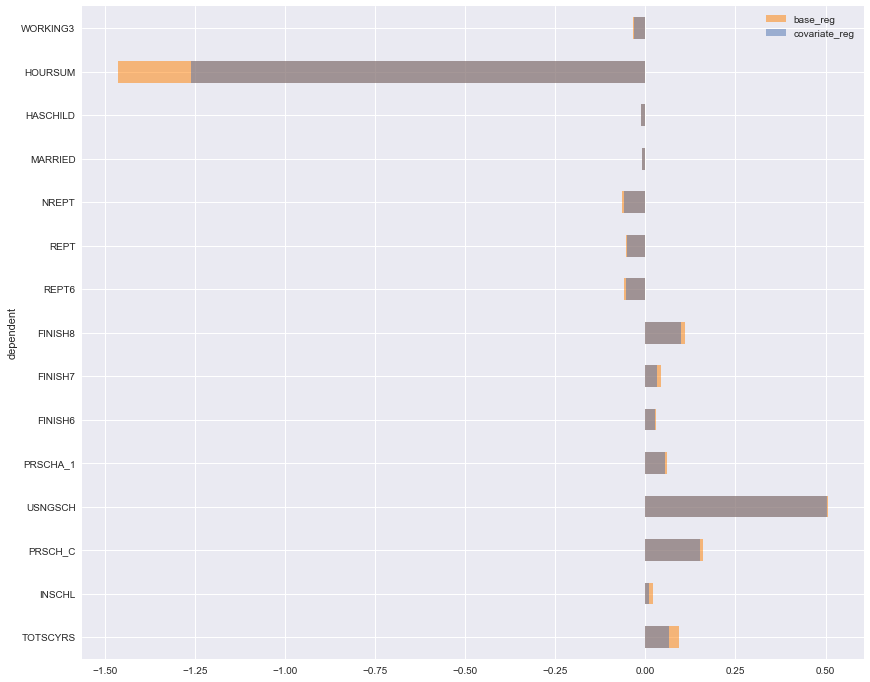

In [100]:
alpha = []
alpha_with_covariates = []
alpha_with_covariates_std = []

for i, outcome in enumerate(dependent):
    formula_1 = dependent[i] + '~' + 'VOUCH0' 
    formula_2 = dependent[i] + '~' + 'VOUCH0 ' + covariates
    
    y_1, X_1 = dmatrices(formula_1,
                         data = df_95,
                        return_type = 'dataframe')
    y_2, X_2 = dmatrices(formula_2,
                         data = df_95,
                        return_type = 'dataframe')
    
    results_1 = sm.OLS(y_1, X_1).fit(cov_type = 'HC0')
    results_2 = sm.OLS(y_2, X_2).fit(cov_type = 'HC0')
    a = results_1.params[1]
    b = results_2.params[1]
    alpha.append(a)
    alpha_with_covariates.append(b)
    alpha_with_covariates_std.append(results_2.bse[1])

res_df = pd.DataFrame({'dependent':dependent,
              'base_reg': alpha,
             'covariate_reg':alpha_with_covariates})

fig, axs = plt.subplots(1, 1)
res_df.plot.barh(x='dependent', y='base_reg', figsize=(14,12), color = '#ff7f00', ax = axs, alpha = 0.5)
res_df.plot.barh(x='dependent', y='covariate_reg', figsize=(14,12), ax = axs,  alpha = 0.5);

In [101]:
summary = dependent + ['VOUCH0']
df_95.loc[:, summary].groupby('VOUCH0').agg('mean').T

VOUCH0,0.0,1.0
TOTSCYRS,3.607945,3.701014
INSCHL,0.825260,0.846024
PRSCH_C,0.537522,0.696610
USNGSCH,0.055268,0.562500
PRSCHA_1,0.879371,0.938983
FINISH6,0.930915,0.961149
FINISH7,0.837651,0.880068
FINISH8,0.625216,0.736486
REPT6,0.190893,0.130508
REPT,0.217617,0.163851


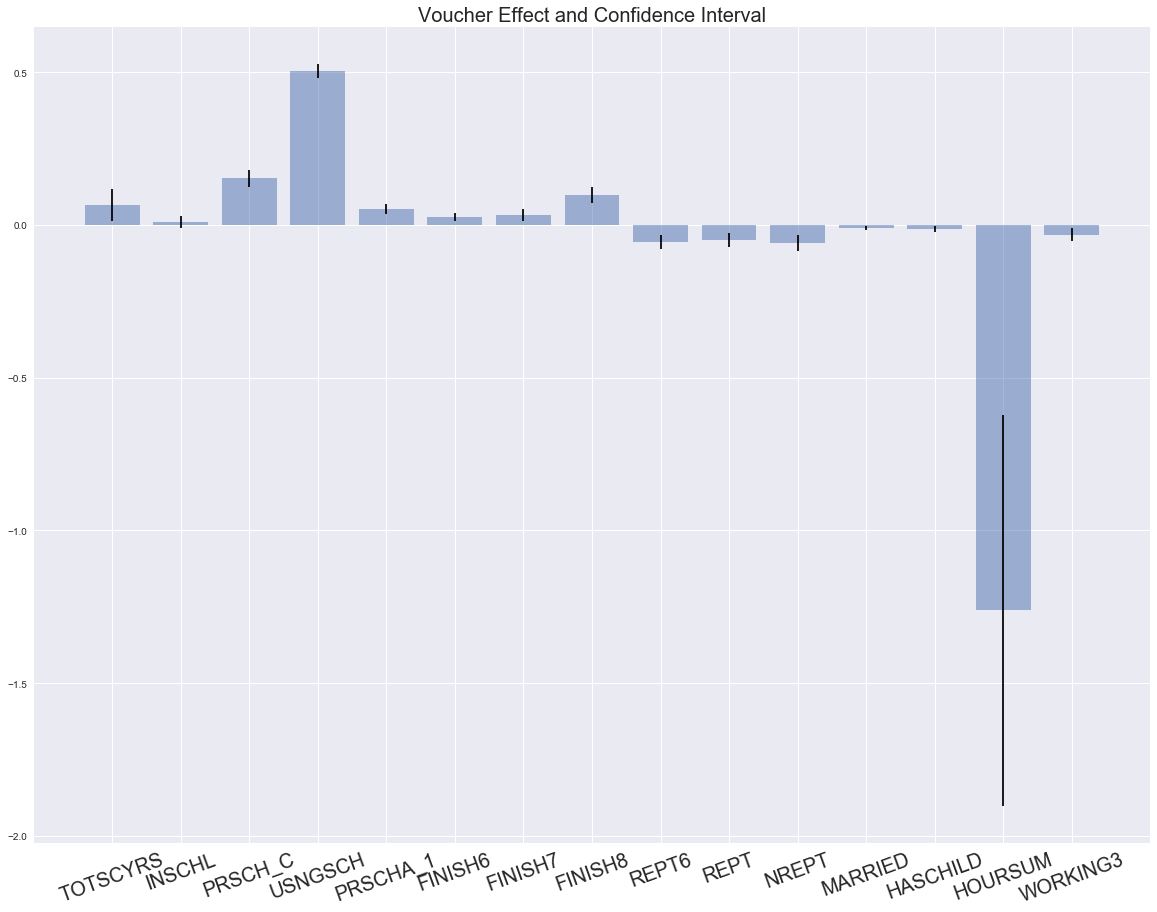

In [102]:
fig, ax = plt.subplots(figsize = (20, 15))
estimates = res_df.covariate_reg.values

x_pos = np.arange(len(estimates))
ax.bar(x_pos, estimates, yerr=alpha_with_covariates_std, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(dependent,  fontsize = 20, rotation = 20)
ax.yaxis.grid(True)
ax.set_title('Voucher Effect and Confidence Interval', fontsize = 20);

### 解釈

- `PRSCHA_1`の結果を見ると6ppt 上昇効果
- controlも87%程度私立でスタートしているため、学費が半額になっても上昇効果は薄くなってしまう（そもそも申請の段階で私立学校の入学許可の提出が求められることも影響）
- `USNGSCH`: 奨学金利用率は50 
- `PRSCH_C`: 継続的に私立学校に通う傾向を確認できる
- `REPET, NREPET`：留年しなくなる傾向が確認できる



### 性別による効果差

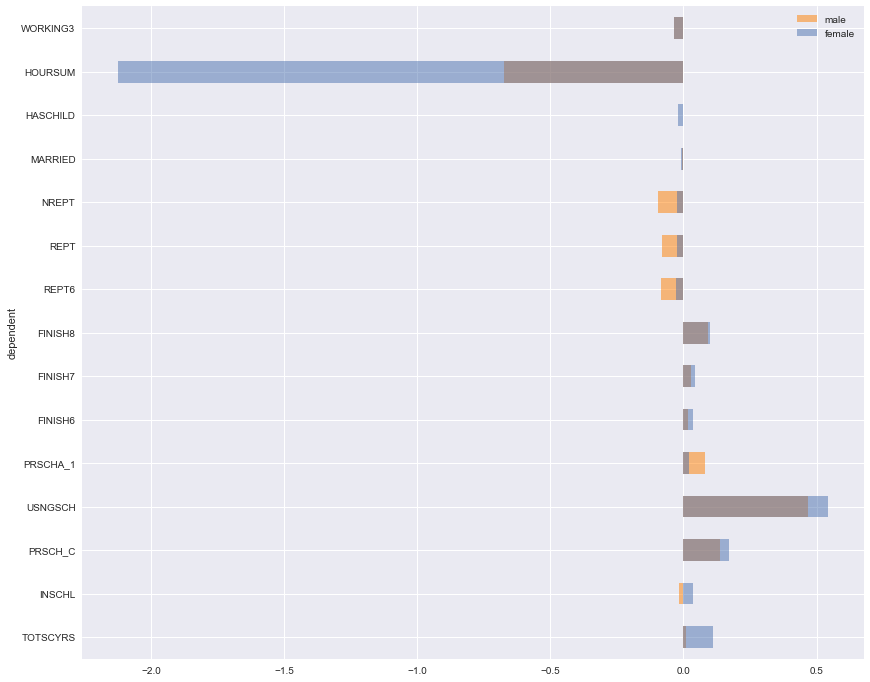

In [103]:
male = []
female = []
male_std = []
female_std = []

isfemale = df_95['SEX2'] < 0.5
ismale = df_95['SEX2'] > 0.5


for i, outcome in enumerate(dependent):
    formula_2 = dependent[i] + '~' + 'VOUCH0 ' + covariates
    
    y_1, X_1 = dmatrices(formula_2,
                         data = df_95[ismale],
                        return_type = 'dataframe')
    y_2, X_2 = dmatrices(formula_2,
                         data = df_95[isfemale],
                        return_type = 'dataframe')
    
    results_1 = sm.OLS(y_1, X_1).fit(cov_type = 'HC0')
    results_2 = sm.OLS(y_2, X_2).fit(cov_type = 'HC0')
    a = results_1.params[1]
    b = results_2.params[1]
    male.append(a)
    female.append(b)
    male_std.append(results_1.bse[1])
    female_std.append(results_2.bse[1])

res_df = pd.DataFrame({'dependent':dependent,
              'male': male,
             'female':female})

fig, axs = plt.subplots(1, 1)
res_df.plot.barh(x='dependent', y='male', figsize=(14,12), color = '#ff7f00', ax = axs, alpha = 0.5)
res_df.plot.barh(x='dependent', y='female', figsize=(14,12), ax = axs,  alpha = 0.5);

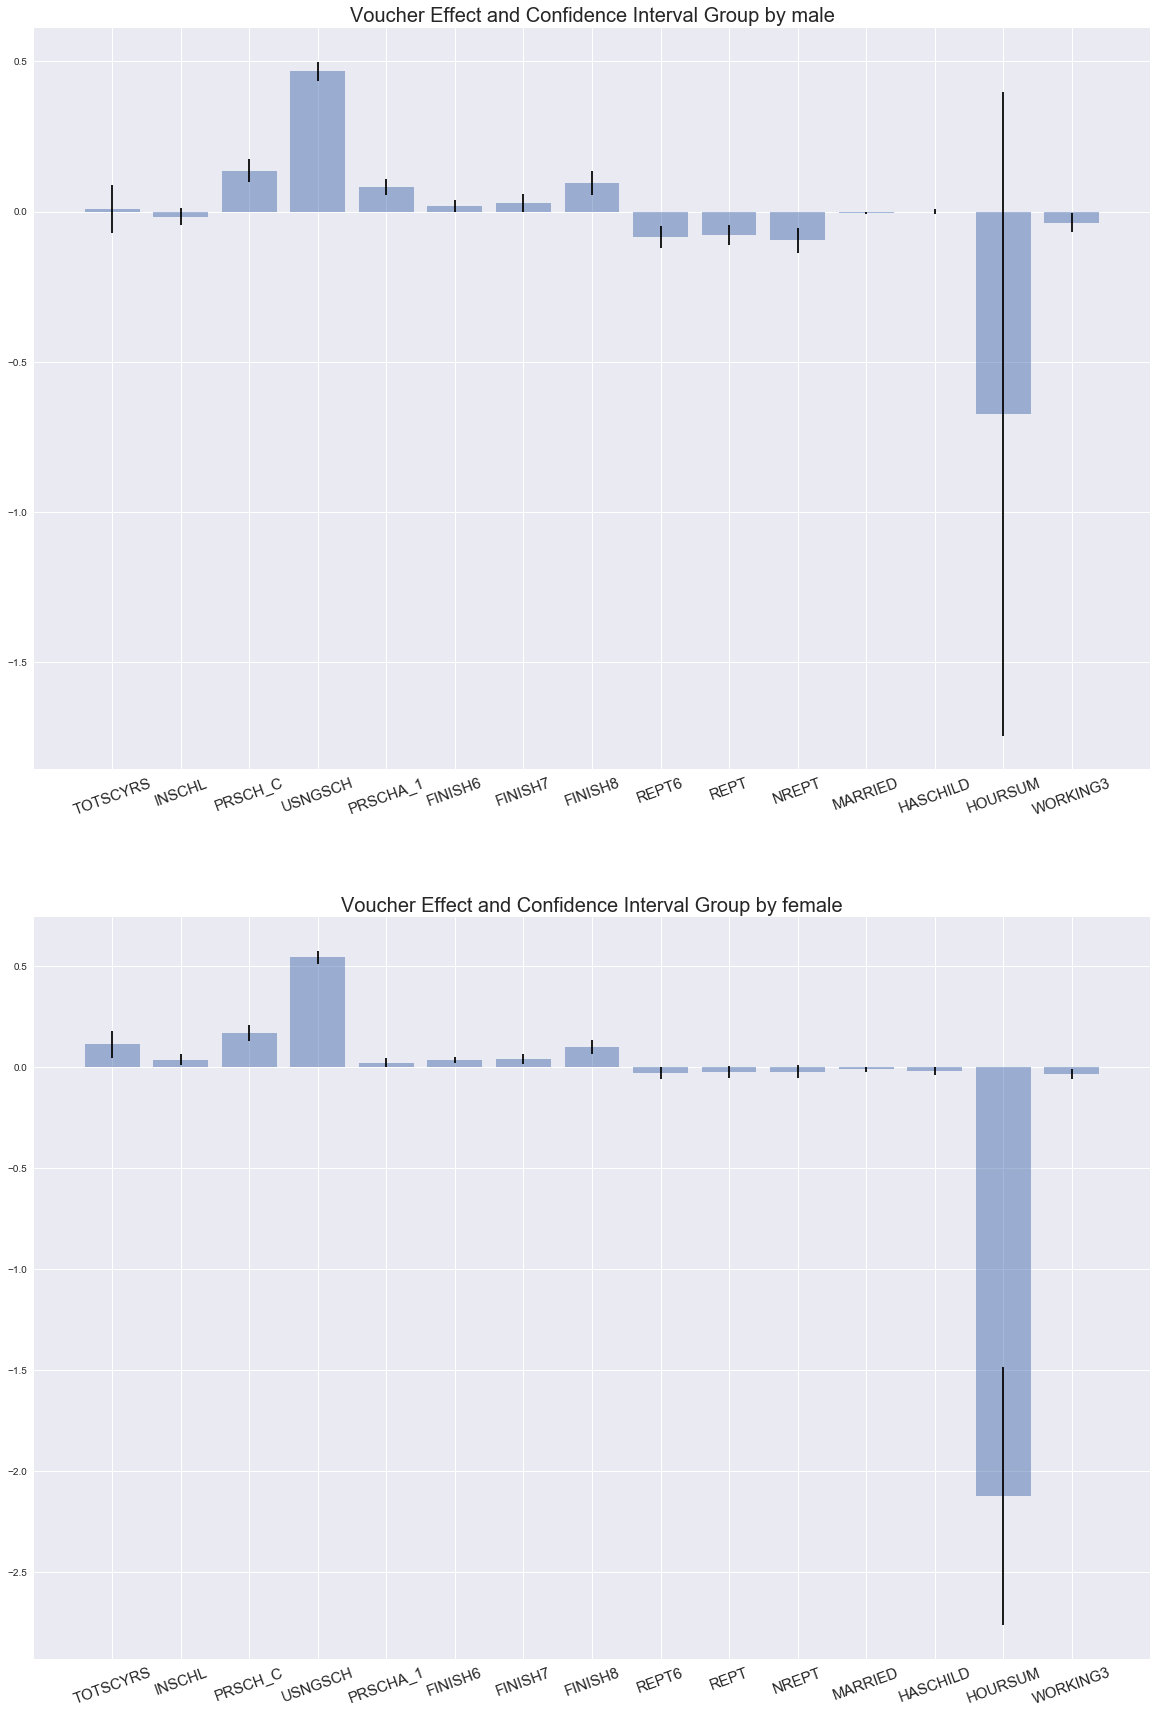

In [104]:
fig, ax = plt.subplots(2,1, figsize = (20, 30))

x_pos = np.arange(len(male))
ax[0].bar(x_pos, male, yerr=male_std, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1].bar(x_pos, female, yerr=female_std, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
for i in [0, 1]:
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(dependent,  fontsize = 15, rotation = 20)
    ax[i].yaxis.grid(True)
    ax[i].set_title('Voucher Effect and Confidence Interval Group by {}'.format(['male', 'female'][i]), fontsize = 20);